# Required Packages

In [ ]:
!pip install torch_geometric
!pip install torch_sparse
!pip install torch_scatter
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 8.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0-py3-none-any.whl size=687167 sha256=7124596a93338e68763453b30653b2262c9211b5781b569b4d15096d7822f4cf
  Stored in directory: /root/.cache/pip/wheels/95/9b/21/7a21b39bcea8f520c9cf2f0eca06e97cd81d02b0ef42ce4942
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 154 kB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.14-cp37-cp37m-linux_x86_64.whl size=497879 sha256=459f189a08787e65f78ed656c1bacebf5426c9b957632317d820d9a0664f3f7d
  Stored in directory: /root/.cache/pip/wheels/3c/aa/62/db0259eae2abce84f1ee2cf1c531bba683aab4bf79054172f8
Successfully built torch-sparse
Looking in indexes: https://pypi.org/simple, https://us-python.p

# Importing required packages

In [2]:
# Base Modules
import numpy as np
import json
import re
import copy
from datetime import datetime
import datetime
import random
import math
import os

# import sys, os
# ^ These packages are required if you are to download this file in your own IDE
#   and want to import files from a filepath

# Pytorch Modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

# Metric Plotting and Visualization
from tensorboardX import SummaryWriter
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Creating the Dataset
from torch_scatter import scatter
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

# Creatin the Neural Network for Testing
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch.optim as optim



# Converting .json files to .unf files

## unf_utils

### Citation:
Kuťák D, Poppleton E, Miao H, Šulc P, Barišić I. Unified Nanotechnology Format: One Way to Store Them All. Molecules. 2021 Dec 23;27(1):63. doi: 10.3390/molecules27010063. PMID: 35011301; PMCID: PMC8746876.

### For more on .unf formatting documentation: 
https://github.com/barisicgroup/unf

In [3]:
DNA_PDB_BASES = ["DA", "DG", "DT", "DC", "DU"]

RNA_PDB_BASES = ["A", "G", "T", "C", "U"]

AA_PDB_RESNAMES = ["HIS", "ARG", "LYS", "ILE", "PHE", "LEU", "TRP"
  "ALA", "MET", "PRO", "CYS", "ASN", "VAL", "GLY", "SER", "GLN", "TYR"
  "ASP", "GLU", "THR", "SEC", "PYL"]

NUCLEOBASE_RING_COMMON_ATOMS = ["C2", "C4", "C5", "C6", "N1", "N3"]

def initialize_unf_file_data_object(name, author, lenUnits = "A", angUnits = "deg"):
    unfFileData = {}

    unfFileData['format'] = "unf"
    unfFileData['version'] = "1.0.0"
    unfFileData['idCounter'] = 0
    unfFileData['lengthUnits'] = lenUnits
    unfFileData['angularUnits'] = angUnits
    unfFileData['name'] = name
    unfFileData['author'] = author
    unfFileData['creationDate'] = datetime.datetime.now().replace(microsecond=0).isoformat()
    unfFileData['doi'] = "NULL"
    unfFileData['simData'] = {}
    unfFileData['simData']['boxSize'] = []
    unfFileData['externalFiles'] = []
    unfFileData['lattices'] = []
    unfFileData['structures'] = []
    unfFileData['groups'] = []
    unfFileData['connections'] = []
    unfFileData['modifications'] = []
    unfFileData['comments'] = []
    unfFileData['misc'] = {}
    unfFileData['molecules'] = {}
    unfFileData['molecules']['ligands'] = []
    unfFileData['molecules']['nanostructures'] = []
    unfFileData['molecules']['others'] = []

    return unfFileData

def is_dna_res(resName):
    return resName in DNA_PDB_BASES

def is_rna_res(resName):
    return resName in RNA_PDB_BASES

def is_protein_res(resName):
    return resName in AA_PDB_RESNAMES

def is_drna_backbone(atomName):
    return "P" in atomName or "'" in atomName

def normalize(np_vector):
    return np_vector / np.sqrt(np.sum(np_vector**2))

def dec_color_to_hex(decimalColor):
    result = "#"
    hexRes = hex(decimalColor).replace("0x", "")
    for i in range(0, 6 - len(hexRes)):
        result += "0"
    result += hexRes
    return result

# Expects hex string of form #RRGGBB
def hex_color_to_dec(hexColor):
    if len(hexColor) != 7:
        return int("00FF00", 16)
    return int(hexColor[1:], 16)
################################################################################


LATTICE_SQUARE = "square"
LATTICE_HONEYCOMB = "honeycomb"
OUTPUT_FILE_NAME = "output.unf"

LSQ_INIT_ANGLE = 15
LHC_INIT_ANGLE = 160

# Indices of the corresponding prev/next vstrand/base ids
# in the cadnano's json file fields
CADNANO_PREV_VID = 0
CADNANO_PREV_BID = 1
CADNANO_NEXT_VID = 2
CADNANO_NEXT_BID = 3

globalIdGenerator = 0

# Strand part corresponds to a number of nucleotides being located at a particular location in a strand
class StrandPart:
    def __init__(self, globalId, vhelixId, baseId, prevVid, prevBid, nextVid, nextBid, nuclToRepresent, insIds):
        self.globalId = globalId
        self.vhelixId = vhelixId
        self.baseId = baseId
        self.prevVid = prevVid
        self.prevBid = prevBid
        self.nextVid = nextVid
        self.nextBid = nextBid
        # Nucl to represent stores the number of nucleotides represented by this strand part
        # For deletion, it is < 0, for normal cell 0 or 1, for insertion > 1
        self.nuclToRepresent = nuclToRepresent
        self.insertedNuclIds = insIds
        self.set_prev_next(None, None)
        self.set_prev_next_arr_pos(None, None)
        self.set_arr_pos(None)

    def __repr__(self):
        return ("vid: " + str(self.vhelixId) + ", bid " + str(self.baseId) + ", type " + self.get_strand_type() + "\n\t prev: " +
         ("None" if self.prevPart is None else str(self.prevPart.globalId)) + 
         "\n\t next: " + ("None" if self.nextPart is None else str(self.nextPart.globalId)))

    def set_prev_next(self, prevPart, nextPart):
        self.prevPart = prevPart
        self.nextPart = nextPart
    
    def set_prev_next_arr_pos(self, prevPos, nextPos):
        self.prevPartPos = prevPos
        self.nextPartPos = nextPos
    
    def set_arr_pos(self, pos):
        self.arrPos = pos

    def get_strand_type(self):
        if self.nuclToRepresent < 0:
            return "deletion"
        elif self.nuclToRepresent > 1:
            return "insertion of size " + str(self.nuclToRepresent - 1)
        else:
            return "normal"
    
    def get_unf_cell_type(self):
        if self.nuclToRepresent < 0:
            return "d"
        elif self.nuclToRepresent > 1:
            return "i"
        else:
            return "n"

class Vhelix:
    def __init__(self, id, row, col, latticeType, firstActiveCell, lastActiveCell, lastCell, stapColors):
        self.id = id
        self.row = row
        self.col = col
        self.latticeType = latticeType
        self.firstActiveCell = firstActiveCell
        self.lastActiveCell = lastActiveCell
        self.lastCell = lastCell
        self.stapColors = stapColors
    
    def __repr__(self):
        return ("vhelix: " + str(self.id) + " [" + str(self.row) + "," + str(self.col) +
         "] fac " + str(self.firstActiveCell) + ", lac " + 
         str(self.lastActiveCell) + ", lc " + str(self.lastCell))

def generate_component(startPart, components, partsProcessed):
    partsProcessed[startPart.arrPos] = True
    newComponent = []
    currPart = startPart
    newComponent.append(currPart)
    while currPart.nextPart != None:
        currPart = currPart.nextPart
        partsProcessed[currPart.arrPos] = True
        newComponent.append(currPart)
    components.append(newComponent)

def create_strand_components(strandArray):
    # Connect the parts together
    i = 0
    for strandPart in strandArray:
        prevIdx = next((i for i, x in enumerate(strandArray) if x.vhelixId == strandPart.prevVid and x.baseId == strandPart.prevBid), None)
        nextIdx = next((i for i, x in enumerate(strandArray) if x.vhelixId == strandPart.nextVid and x.baseId == strandPart.nextBid), None)

        prevPart = strandArray[prevIdx] if prevIdx != None else None
        nextPart = strandArray[nextIdx] if nextIdx != None else None
        
        strandPart.set_prev_next_arr_pos(prevIdx, nextIdx)
        strandPart.set_prev_next(prevPart, nextPart)
        strandPart.set_arr_pos(i)
        i += 1
    
    i = 0
    circCount = 0
    components = []
    partsProcessed = [False] * len(strandArray)

    for strandPart in strandArray:
        if partsProcessed[strandPart.arrPos] == True:
            continue

        # If this part has no previous part, then it is 5' nucleotide
        # and we can generate the whole strand component starting from it
        if strandPart.prevPart == None:
            generate_component(strandPart, components, partsProcessed)
        # If this part has a previous part, we need to check for circularity
        else:
            start = strandPart
            currPart = start
            isCirc = False
            while currPart.prevPart != None:
                currPart = currPart.prevPart
                if currPart == start:
                    isCirc = True
                    break
                elif currPart.prevPart == None:
                    generate_component(currPart, components, partsProcessed)
            # If circularity was detected, we need to process this component separately
            if isCirc:
                newComponent = []
                currPart = start
                partsProcessed[currPart.arrPos] = True
                newComponent.append(currPart)
                while currPart.nextPart != start:
                    currPart = currPart.nextPart
                    partsProcessed[currPart.arrPos] = True
                    newComponent.append(currPart)
                components.append(newComponent)
                circCount += 1                
        i += 1

    return (components, circCount)

def process_cadnano_file(file_path, lattice_type):
    print("Loading structure '" + file_path + "' with " + lattice_type + " lattice.\n")
    
    file = open(file_path, "r")
    parsedData = json.loads(file.read())

    processedVhelices = []
    allScaffoldRecords = []
    allStapleRecords = []
    global globalIdGenerator

    for vstr in parsedData['vstrands']: 
        firstActiveCell = max(len(vstr['stap']), len(vstr['scaf']))
        lastActiveCell = 0
        lastCell = 0

        arrToProcess = [(vstr['scaf'], allScaffoldRecords, "scaffold"), (vstr['stap'], allStapleRecords, "staple")]

        for arrDestPair in arrToProcess:
            for idx, strRec in enumerate(arrDestPair[0]):
                isValidRecord = strRec[CADNANO_PREV_VID] >= 0 or strRec[CADNANO_NEXT_VID] >= 0
                nuclToRepr = vstr['skip'][idx] if vstr['skip'][idx] < 0 else ((vstr['loop'][idx] + 1) if vstr['loop'][idx] > 0 else 1)
                if isValidRecord:
                    thisId = globalIdGenerator
                    globalIdGenerator += 1
                    insIds = []
                    for lId in range(nuclToRepr - 1):
                        insIds.append(globalIdGenerator)
                        globalIdGenerator += 1
                    arrDestPair[1].append(StrandPart(thisId, vstr['num'], idx, strRec[CADNANO_PREV_VID], 
                    strRec[CADNANO_PREV_BID], strRec[CADNANO_NEXT_VID], strRec[CADNANO_NEXT_BID], nuclToRepr, insIds))
                lastCell = max(lastCell, idx)
                # if nuclToRepr < 0 or nuclToRepr > 1:
                    #print("Found", arrDestPair[2], arrDestPair[1][-1].get_strand_type())

                firstActiveCell = min(firstActiveCell, idx if isValidRecord else firstActiveCell)
                lastActiveCell = max(lastActiveCell, idx if isValidRecord else lastActiveCell)
        
        processedVhelices.append(Vhelix(vstr['num'], vstr['row'], vstr['col'], lattice_type, firstActiveCell, lastActiveCell, lastCell, vstr['stap_colors']))

    individualScaffoldStrands = create_strand_components(allScaffoldRecords)
    individualStapleStrands = create_strand_components(allStapleRecords)


    #print("Found:", len(processedVhelices), "virtual helices,", len(individualScaffoldStrands[0]),
    # "scaffolds (", individualScaffoldStrands[1], " circular ),", len(individualStapleStrands[0]),
    #  "staples (", individualStapleStrands[1], " circular ).")

    # for vhelix in processedVhelices:
    #     print(" Virtual helix: ", str(vhelix))
    
    # for strandComp in individualScaffoldStrands[0]:
    #     print(" Scaffold strand routed via", len(strandComp), "cells")

    # for strandComp in individualStapleStrands[0]:
    #     print(" Staple strand routed via", len(strandComp), "cells")     
    
    print()

    file.close()

    return (processedVhelices, individualScaffoldStrands[0], individualStapleStrands[0])

def strands_to_unf_data(unfFileData, thisStructure, strandsList, allStrandParts, areScaffolds, stapleStartToColor):
    resultingObjects = []
    r = lambda: random.randint(0, 230)
    global globalIdGenerator

    for strand in strandsList:
        # Each strand is an array of strand parts (StrandPart).
        # Since one strand part may represent different number of nucleotides
        # or possibly none at all, the parts will be preprocessed to work
        # with a consecutive sequence of nucleotides where deleted ones are omitted
        # and insertions are "expanded".
        
        # Index i refers to i-th nucleotide of a strand
        # Its next/prev nucleotides have neighboring IDs in the ntIds array
        ntIds = []
        ntPairs = []
        
        strandColor = ""

        for strandPart in strand:
            cellType = strandPart.get_unf_cell_type()
            if cellType == "n":
                ntIds.append(strandPart.globalId)
                ntPairs.append(next((x.globalId for y in allStrandParts for x in y if x.vhelixId == strandPart.vhelixId and
                 x.baseId == strandPart.baseId and x.globalId != strandPart.globalId), -1))
            elif cellType == "i":
                idsToAdd = [strandPart.globalId] + strandPart.insertedNuclIds
                pairPart = next((x for y in allStrandParts for x in y if x.vhelixId == strandPart.vhelixId and
                 x.baseId == strandPart.baseId and x.globalId != strandPart.globalId), None)

                pairsToAdd = []
                if pairPart != None:
                    pairsToAdd = pairPart.insertedNuclIds[::-1] + [pairPart.globalId]
                else:
                    pairsToAdd = [-1] * len(idsToAdd)
                
                ntIds += idsToAdd
                ntPairs += pairsToAdd
            
            # NOTE Cadnano does not seem to store color for circular staples
            #      Therefore, random color is generated for them
            if cellType != "d" and not areScaffolds and len(strandColor) == 0:
                vid = strandPart.vhelixId
                bid = strandPart.baseId
                colRec = stapleStartToColor[(vid, bid)] if (vid, bid) in stapleStartToColor else None
                if colRec != None:
                    strandColor = colRec
            # For deletion, "deletion" cell exists but it contains no nucleotides
            # and is thus ignored on the level of DNA data structure.
            # The resulting strand, therefore, simply "goes through that cell without stopping".

        if len(strandColor) == 0:
            strandColor = "#0000FF" if areScaffolds else "#{:02x}{:02x}{:02x}".format(r(), r(), r())

        strandObject = {}

        strandObject['id'] = globalIdGenerator
        globalIdGenerator += 1
        strandObject['name'] = "DNA_strand"
        strandObject['naType'] = "DNA"
        strandObject['chainName'] = "NULL"
        strandObject['color'] = strandColor
        strandObject['isScaffold'] = areScaffolds
        strandObject['pdbFileId'] = -1
        strandObject['fivePrimeId'] = ntIds[0]
        strandObject['threePrimeId'] = ntIds[-1]

        nucleotides = []
        for i in range(len(ntIds)):
            newNucl = {}
            newNucl['id'] = ntIds[i]
            newNucl['nbAbbrev'] = "N"
            newNucl['pair'] = ntPairs[i]
            newNucl['prev'] = ntIds[i - 1] if i > 0 else -1
            newNucl['next'] = ntIds[i + 1] if i < len(ntIds) - 1 else - 1
            newNucl['pdbId'] = -1
            newNucl['altPositions'] = []

            nucleotides.append(newNucl)

        # Maintain circularity
        circStr = "[acyclic]"
        if strand[-1].nextPart == strand[0]:
            nucleotides[0]['prev'] = ntIds[-1]
            nucleotides[-1]['next'] = ntIds[0]
            circStr = "[circular]"

        strandObject['nucleotides'] = nucleotides
        resultingObjects.append(strandObject)
        # print(circStr, "Scaffold" if areScaffolds else "Staple", "strand object generated with", len(nucleotides), "nucleotides.")
        # print(" Color:", strandColor)

    thisStructure['naStrands'] = thisStructure['naStrands'] + resultingObjects

def convert_data_to_unf_file(latticesData, latticesPositions, latticeOrientations):
    unfFileData = initialize_unf_file_data_object("cadnano_converted_structure", "Cadnano to UNF Python Converter Script")
    global globalIdGenerator
    posId = 0
    count = 0
    for lattData in latticesData:
        vhelices = lattData[0]
        scaffoldStrands = lattData[1]
        stapleStrands = lattData[2]

        allStrandParts = scaffoldStrands + stapleStrands

        outputLattice = {}
        outputLattice['id'] = globalIdGenerator
        globalIdGenerator += 1
        outputLattice['name'] = 'lattice_from_cadnano'
        outputLattice['position'] = [int(pos) for pos in latticesPositions.split(",")]
        outputLattice['orientation'] = [int(rot) for rot in latticeOrientations.split(",")]
        posId += 1
        outputLattice['virtualHelices'] = []

        stapleStartToColor = {}

        for vhelix in vhelices:
            outputVhelix = {}
            outputVhelix['id'] = globalIdGenerator
            globalIdGenerator += 1
            outputVhelix['firstActiveCell'] = vhelix.firstActiveCell
            outputVhelix['lastActiveCell'] = vhelix.lastActiveCell
            outputVhelix['lastCell'] = vhelix.lastCell
            outputVhelix['latticePosition'] = [vhelix.row, vhelix.col]
            outputVhelix['initialAngle'] = LSQ_INIT_ANGLE if vhelix.latticeType == LATTICE_SQUARE else LHC_INIT_ANGLE 
        
            outputLattice['type'] = vhelix.latticeType

            for stapColPair in vhelix.stapColors:
                stapleStartToColor[(vhelix.id, stapColPair[0])] = dec_color_to_hex(stapColPair[1])

            cells = []
            for i in range(vhelix.lastActiveCell + 1):
                newCell = {}
                newCell['id'] = globalIdGenerator
                globalIdGenerator += 1
                newCell['number'] = i
                newCell['type'] = "n"
                newCell['fiveToThreeNts'] = []
                newCell['threeToFiveNts'] = []

                # The purpose of this (computationally not ideal) code is to
                # find out the directionality of this strand in this virtual helix.
                for sp in allStrandParts:
                    for x in sp:
                        if x.vhelixId == vhelix.id and x.baseId == i:
                            currPart = x
                            cellType = currPart.get_unf_cell_type()
                            newCell['type'] = cellType        
                            
                            if cellType != "d":
                                strVhelixStartPart = currPart.prevPart if currPart.prevPart != None and currPart.prevPart.vhelixId == vhelix.id else currPart
                                strVhelixEndPart = currPart.nextPart if currPart.nextPart != None and currPart.nextPart.vhelixId == vhelix.id else currPart
                                
                                # We can afford "and" instead of "or" because the start/end parts are initialized
                                # with this strand part and the comparsion includes equality
                                if strVhelixStartPart.baseId <= currPart.baseId and strVhelixEndPart.baseId >= currPart.baseId:
                                    if len(newCell['fiveToThreeNts']) > 0:
                                        print("Error! Rewriting content of a valid cell", vhelix.row,
                                         vhelix.col, i, "with a new 5'3' value.", newCell['fiveToThreeNts'], "->", currPart.globalId)
                                    newCell['fiveToThreeNts'] = [currPart.globalId] + currPart.insertedNuclIds
                                elif strVhelixStartPart.baseId >= currPart.baseId and strVhelixEndPart.baseId <= currPart.baseId:
                                    if len(newCell['threeToFiveNts']) > 0:
                                        print("Error! Rewriting content of a valid cell", vhelix.row, 
                                        vhelix.col, i, "with a new 3'5' value.", newCell['threeToFiveNts'], "->", currPart.globalId)
                                    newCell['threeToFiveNts'] = [currPart.globalId] + currPart.insertedNuclIds
                    if len(newCell['fiveToThreeNts']) > 0 and len(newCell['threeToFiveNts']) > 0:
                        break
              
                cells.append(newCell)

            outputVhelix['cells'] = cells
            outputLattice['virtualHelices'].append(outputVhelix)

        unfFileData['lattices'].append(outputLattice)

        newStructure = {}
        newStructure['id'] = globalIdGenerator
        globalIdGenerator += 1
        newStructure['name'] = "Multilayer structure"
        newStructure['naStrands'] = []
        newStructure['aaChains'] = []
        strands_to_unf_data(unfFileData, newStructure, scaffoldStrands, allStrandParts, True, stapleStartToColor)
        strands_to_unf_data(unfFileData, newStructure, stapleStrands, allStrandParts, False, stapleStartToColor)
        unfFileData['structures'].append(newStructure)
        # et = time.time()
        # differenceInTime = et - st
        # print(f"Time taken to convert to UNF file for lattice{origamiNames[count]}: {differenceInTime} seconds")
        # print()
        count += 1
    
    unfFileData['idCounter'] = globalIdGenerator

    '''
    We remove this line of code because we originally wanted to have these .unf files
    stored in a list

    We implement this feature in a separate part for improving runtime
    '''
    # with open(OUTPUT_FILE_NAME, 'w') as outfile:
    #     json.dump(unfFileData, outfile)
    return unfFileData # modified feature

## UNF File Conversion Functions

In [4]:
def makeUNFFiles(filepath, latticesPositions="0,0,0", latticeOrientations="0,0,0"):
  """
  Returns the UNF File as a list of objects.

  Parameters
  ----------
  [filepath: str]
    The filepath of where the DNA Origami nanostructures are obtained from.

  [latticesPositions / latticeOrientations: str]
    The orientation at which all the DNA nanostructures are oriented by
    in terms of x,y,z coordinates. Default values are '0,0,0' for both
    parameters.
"""
  origamiNames = os.listdir(filepath)
  if ('.DS_Store' in origamiNames):
      indexOfRemovingElem = origamiNames.index('.DS_Store')
      origamiNames.pop(indexOfRemovingElem)
      
  processedFilesData = list()
  for origamiName in origamiNames:
      origamiFilePath = f"{filepath}/{origamiName}" 
      f = open(origamiFilePath, "r")
      data = json.loads(f.read())
      num_bases = len(data['vstrands'][0]['scaf'])
      if (num_bases % 32 == 0):
        latticeType = "square"
      elif (num_bases % 21 == 0):
        latticeType = "honeycomb"
      processedFilesData.append(process_cadnano_file(origamiFilePath, latticeType))
  filesData = convert_data_to_unf_file(processedFilesData, "0,0,0", "0,0,0")
  return filesData

def dumpUNFFiles(unfFiles, fileOutputName):
  with open(fileOutputName, 'w') as outfile:
    json.dump(unfFiles, outfile)

def importUNFFile(unfFilepath):
  """
      Imports a UNF file.

      Parameters
      ----------
      [unfFilepath: str]
          The filepath of where the DNA Origami nanostructures in .unf format are obtained from.
  """

  fTmp = open(unfFilepath, "r")
  fileContent = fTmp.read()
  jsonPartEndIdx = fileContent.find("#INCLUDED_FILE ")
  if jsonPartEndIdx > -1:
      jsonPart = fileContent[0:jsonPartEndIdx]
  else:
      jsonPart = fileContent
  parsedData = json.loads(jsonPart)
  filesData = parsedData
  return filesData


# Helper Functions

In [6]:
def maxIsSmallThanAll(ls1, ls2):
    """
    Given two lists (ls1, ls2), returns whether the maximum-valued element in ls1
    is smaller than all elements in ls2.
    """
    maxNum = max(ls1)
    minNum = min(ls2)
    return maxNum < minNum

def getHelixFromGraph(nucleotide, graph): 
  assert(nucleotide in graph.keys() and (isinstance(graph[nucleotide], tuple) or isinstance(graph[nucleotide], list)))
  return graph[nucleotide][0]

def getCellFromGraph(nucleotide,graph):
  assert(nucleotide in graph.keys() and (isinstance(graph[nucleotide], tuple) or isinstance(graph[nucleotide], list)))
  return graph[nucleotide][1]

def getKeyFromVal(val, dictionary):
    assert(isinstance(dictionary, dict) and val in dictionary.values())
    return list(dictionary.keys())[list(dictionary.values()).index(val)]
    
def getAllKeysFromVal(val, dictionary):
    assert(isinstance(dictionary, dict) and val in dictionary.values())
    keys = list()
    for key in dictionary.keys():
        if (dictionary[key] == val):
            keys.append(key)
    return keys

def isValidCellType(cellType):
    return (isinstance(cellType, str) or cellType != "d" or cellType != "s" or cellType != "i" or cellType != "n")

def getSecondValueOfTuple(position):
    return position[1]

def getFirstValueOfTuple(position):
    return position[0]

def allContainsTwo(ls):
    assert(isinstance(ls, list))
    for elem in ls:
        if (not isinstance(elem, list)):
            return False
        if (len(elem) != 2):
            return False
    return True

# key: value --> node: neighbors
def neighborListToDict(ls):
    assert(isinstance(ls, list) and allContainsTwo(ls))
    neighborsDict = dict()
    for elem in ls:
        if (elem[0] not in neighborsDict.keys()):
            neighborsDict[elem[0]] = list()
        if (elem[1] not in neighborsDict.keys()):
            neighborsDict[elem[1]] = list()
        neighborsDict[elem[0]].append(elem[1])
        neighborsDict[elem[1]].append(elem[0])
    return neighborsDict

def is2DList(tupleList):
    if (not isinstance(tupleList, list)):
        return False
    for elem in tupleList:
        if (not (isinstance(elem, tuple) or isinstance(elem, list))):
            return False
    return True

def TwoDimListSort(tupleList):
    assert(is2DList(tupleList))
    tmp = sorted(tupleList, key = getSecondValueOfTuple)
    sortedPositions = sorted(tmp, key = getFirstValueOfTuple)
    return sortedPositions

def allLsValues(dictionary):
    assert(isinstance(dictionary, dict))
    for key in dictionary.keys():
        if (not isinstance(dictionary[key], list)):
            return False
    return True

def followsGraphFormat(graph):
    if (not isinstance(graph, dict)):
        return False
    for key in graph.keys():
        if (not isinstance(key, tuple) or (key[0] < 0 or key[1] < 0)):
            return False
        neighbors = graph[key]
        if (not (isinstance(neighbors, tuple) or isinstance(neighbors, list) or isinstance(neighbors, set))):
            return False
        for neighbor in neighbors:
            if (not isinstance(neighbor, tuple) or neighbor not in graph.keys() or (neighbor[0] < 0 or neighbor[1] < 0)):
                return False
    return True


# Constructing the Dictionary Pertaining to Each Nucleotide's Properties

In [5]:
def makeRequiredListsAndDicts(fileIndex, filesData):
    """
    The first step in creating the graph structure is to create a dictionaries 
    describing the properties of each node of the graph structure. This way, we
    can reference the properties of each nucleotide in O(1) time for future reference.
    
    This function is the first step of this process. There are two ways in which
    we can parse out the .unf structure, as mentioned in the .unf documentation.
    The first way is to observe every nucleotide by going from cell to cell on a helix;
    another way of phrasing this method is by iterating through each cell row-by-row.
    Once this process is performed, we return the dictionaries that were created through
    this process.

    Returns lists and dictionaries that describe each nucleotide's properties,
    including: their (helix, cell) position, their cell type (insertion, deletion, normal),
    and whether they're the first or last nucleotide on a DNA origami segment

    Note that, because cells that contain deletions don't have nucleotide IDs in
    the .unf structure, we create the deletion IDs in this function.

    Parameters
    ----------
    [fileIndex: int]
      the index of the file in filesData

    [filesData: dict]
      all of the .unf structures; assumes that filesData is properly converted to
      the .unf formatting
    """

    nucIDToCellType = dict()
    prevIDsFiveThree = list()

    prevIDsThreeFive = list()
    deletionIDs = set()
    deletionCount = 0

    isFirstOrLastList = list()
    nucIDToGraphTuple = dict()

    helixCountDebug = -1


    helixCount = len(filesData["lattices"][fileIndex]["virtualHelices"])

    startingHelix = copy.copy(helixCount - 1)

    nucIDToGraphTuple = dict()


    for helix in filesData["lattices"][fileIndex]["virtualHelices"]:
        prevCellType = "s"
        prevCell = "NA"
        helixCount -= 1
        cellCount = -1
        helixCountDebug += 1
        assert(helixCount >= 0)

        lastActiveCell = helix["lastActiveCell"]
        lastCell = helix["lastCell"]

        # Accounting for deletions on the start of a helix
        hasHitDeletionOnStart = False
        hasReachedNonDeletionStart = False
        minIDStartingCell = "NA"
        maxIDEndingCellPrevHelix = "NA"

        delIDCellTypeLs = list()
        delIDToGraphLs = list() 

        nonDelID5to3 = set()
        nonDelID3to5 = set()
        middleDelIDCellTypeLs = list()
        middleDelIDToGraphLs = list()

        numberDeletionsAtEnd = 0
        endDelIDCellTypeLs = list()
        endDelIDToGraphLs = list()

        allNonDelIDs = set()

        for cell in helix["cells"]:
            cellCount += 1
            latticePosition = helix["latticePosition"]
            cellNumber = cell["number"]
            cellIDFiveThree = cell["fiveToThreeNts"]
            cellIDThreeFive = cell["threeToFiveNts"]

            allNAs = list()
            for elem in cellIDThreeFive:
                allNAs.append(elem)
                allNonDelIDs.add(elem)
            for elem in cellIDFiveThree:
                allNAs.append(elem)
                allNonDelIDs.add(elem)

            
            numNAsInCell = len(cellIDFiveThree) + len(cellIDThreeFive)
            cellType = cell["type"]
            assert(cellType == "n" or cellType == "i" or cellType == "d")
            # What to do about nicks?
            if (cellType == "n" and numNAsInCell == 0):
                cellType = "s"

            #### Determining if the nucleotide is the first or last elem in a cell segment:
            if (cellType != "s" and (prevCellType == "s" or helix["cells"][-1] == cell)):
                for nucID in allNAs:
                    isFirstOrLastList.append(nucID)
            elif (prevCellType != "s" and cellType == "s"):
                assert(prevCell != "NA")
                allPrevNAs = list()
                for elem in prevCell["fiveToThreeNts"]:
                    allPrevNAs.append(elem)
                for elem in prevCell["threeToFiveNts"]:
                    allPrevNAs.append(elem)
                for nucID in allPrevNAs:
                    isFirstOrLastList.append(nucID)
            prevCellType = cellType
            prevCell = cell

            if (cellType != "d" and numberDeletionsAtEnd != 0):
                    middleDelIDCellTypeLs = middleDelIDCellTypeLs + copy.copy(endDelIDCellTypeLs)
                    middleDelIDToGraphLs = middleDelIDToGraphLs + copy.copy(endDelIDToGraphLs)

                    numberDeletionsAtEnd = 0
                    endDelIDCellTypeLs = list()
                    endDelIDToGraphLs = list()

            if (cellType != "s" and cellType != "d"):

                if (hasHitDeletionOnStart and not hasReachedNonDeletionStart):
                    hasReachedNonDeletionStart = True
                    minIDStartingCell = min(allNAs)
                
                for nucID in cellIDFiveThree:
                    nonDelID5to3.add(nucID)
                for nucID in cellIDThreeFive:
                    nonDelID3to5.add(nucID)

                # assign nucleic acids in a particular lattice position to a "graph ID."
                # A nuc. acid and its complementary base will be given the same "graph ID."
                # Multiple nucleic acids assigned to the same lattice position will be given
                # different graph IDs for now.

                for nucID in allNAs:
                    assert(nucID not in nucIDToGraphTuple.keys())
                    assert(nucID not in nucIDToCellType.keys())
                    nucIDToCellType[nucID] = cellType
                    nucIDToGraphTuple[nucID] = [helixCount, cellCount]
            elif (cellType == "d"):
                # Code for deletion IDs: we determine whether it's on the edges of a helix
                # or not, and then label it as such. We then parse out the deletion ID
                # creation based on whether it's on the "beginning edge," "ending edge,"
                # or in the middle of a helix.
                assert(len(prevIDsFiveThree) != 0)
                assert(len(prevIDsThreeFive) != 0)
                assert(max(prevIDsFiveThree) in nucIDToGraphTuple.keys())
                assert(max(prevIDsThreeFive) in nucIDToGraphTuple.keys())

                if (getHelixFromGraph(max(prevIDsFiveThree), nucIDToGraphTuple) == helixCount and getHelixFromGraph(max(prevIDsThreeFive), nucIDToGraphTuple) == helixCount):
                    numberDeletionsAtEnd += 1
                    endDelIDCellTypeLs.append(cellType)
                    endDelIDToGraphLs.append([helixCount, cellCount])

                else:
                    hasHitDeletionOnStart = True
                    if (helixCount != startingHelix):
                        assert(len(prevIDsFiveThree) != 0 and len(prevIDsThreeFive) != 0)
                        maxIDEndingCellPrevHelix = max(max(prevIDsFiveThree), max(prevIDsThreeFive))
                    else:
                        maxIDEndingCellPrevHelix = "NA"
                    delIDCellTypeLs.append(cellType)
                    delIDToGraphLs.append([helixCount, cellCount])
                     
            if (len(cellIDFiveThree) != 0):
                prevIDsFiveThree = cellIDFiveThree
            if (len(cellIDThreeFive) != 0):
                prevIDsThreeFive = cellIDThreeFive
        
        # For Deletions on the beginning of a helical cell:
        if (hasHitDeletionOnStart and hasReachedNonDeletionStart and isinstance(minIDStartingCell, int)):
            if (not isinstance(maxIDEndingCellPrevHelix, int)):
                assert(maxIDEndingCellPrevHelix == "NA")
                assert(helixCount == startingHelix)
                startingIDforDels = min(list(allNonDelIDs))
                numIDforDels = len(delIDToGraphLs)
                idx = 0
                for i in range(1, numIDforDels+1):
                    delID = startingIDforDels - i
                    assert(delID not in deletionIDs)
                    deletionIDs.add(delID)
                    assert(delID not in nucIDToGraphTuple.keys())
                    assert(delID not in nucIDToCellType.keys())
                    nucIDToGraphTuple[delID] = delIDToGraphLs[numIDforDels-1-idx]
                    nucIDToCellType[delID] = "d"
                    deletionCount += 1
                    idx += 1
                    
            else:
                assert(len(delIDToGraphLs) == len(delIDCellTypeLs) and len(delIDToGraphLs) == (minIDStartingCell - maxIDEndingCellPrevHelix - 1))
                for cellTypeElem in delIDCellTypeLs:
                    assert(cellTypeElem == "d")
                
                idx = 0
                for delID in range(maxIDEndingCellPrevHelix+1, minIDStartingCell):
                    assert(delID not in deletionIDs)
                    deletionIDs.add(delID)
                    assert(delID not in nucIDToGraphTuple.keys())
                    assert(delID not in nucIDToCellType.keys())
                    nucIDToGraphTuple[delID] = delIDToGraphLs[idx]
                    nucIDToCellType[delID] = "d"
                    deletionCount += 1
                    idx += 1
        else:
            assert(minIDStartingCell == "NA" and maxIDEndingCellPrevHelix == "NA" and hasHitDeletionOnStart == False and hasReachedNonDeletionStart == False
            and len(delIDToGraphLs) == 0 and len(delIDCellTypeLs) == 0)

        # Code for deletion IDs on the end of the helix:
        if (len(endDelIDCellTypeLs) != 0 and len(endDelIDToGraphLs) != 0):
            #print("Ending Deletion Code:")
            for elem in endDelIDCellTypeLs:
                assert(elem == "d")
            maxIDHelix = max(list(allNonDelIDs))
            assert(maxIDHelix in cellIDFiveThree or maxIDHelix in cellIDThreeFive)
            numEndingDelIDs = len(cellIDThreeFive)
            idx = 0
            for i in range(1, numEndingDelIDs+1):
                delID = maxIDHelix + i
                deletionCount += 1
                assert(delID not in deletionIDs)
                assert(delID not in nucIDToGraphTuple.keys())
                assert(delID not in nucIDToCellType.keys())
                deletionIDs.add(delID)
                nucIDToGraphTuple[delID] = delIDToGraphLs[idx]
                nucIDToCellType[delID] = "d"
                idx += 1
            newMaxID = maxIDHelix + numEndingDelIDs
            prevIDsFiveThree = [newMaxID]

        # Code for deletion IDs in the middle of the helix:
        if (len(middleDelIDCellTypeLs) != 0 and len(middleDelIDToGraphLs) != 0):
            for elem in middleDelIDCellTypeLs:
                assert(elem == "d")
  
            nonDelID5to3Sorted = sorted(list(nonDelID5to3))
            nonDelID3to5Sorted = sorted(list(nonDelID3to5))
            
            sortedIDs = sorted(nonDelID3to5Sorted + nonDelID5to3Sorted)

            for i in range(1, len(sortedIDs)):
                if(sortedIDs[i] - sortedIDs[i-1] != 1 and getCellFromGraph(sortedIDs[i-1], nucIDToGraphTuple) < getCellFromGraph(sortedIDs[i], nucIDToGraphTuple)):
                    addingAmount = 0

                    while (sortedIDs[i] - (sortedIDs[i-1] + addingAmount) != 1): # indicates a gap in the IDs
                        addingAmount += 1
                        delID = sortedIDs[i-1] + addingAmount
                        delIDTmpCellVal = copy.copy(nucIDToGraphTuple[sortedIDs[i-1]])
                        delIDTmpCellVal[1] += addingAmount
                        tmp = copy.copy(delIDTmpCellVal)

                        if (delIDTmpCellVal not in middleDelIDToGraphLs):
                            delIDTmpCellVal[1] -= 2*addingAmount

                        if (delIDTmpCellVal not in middleDelIDToGraphLs):
                            break
                       
                        assert(delIDTmpCellVal in middleDelIDToGraphLs)
                        deletionCount += 1
                        assert(delID not in deletionIDs)
                        deletionIDs.add(delID)
                        assert(delID not in nucIDToGraphTuple.keys())
                        assert(delID not in nucIDToCellType.keys())
                        nucIDToGraphTuple[delID] = delIDTmpCellVal
                        nucIDToCellType[delID] = "d"

    assert(deletionCount == len(deletionIDs))      
    return nucIDToGraphTuple, nucIDToCellType, isFirstOrLastList, deletionIDs

def makeUnfilteredAndFilteredNAs(fileIndex, filesData, nucIDToGraphTuple, nucIDToCellType, isFirstOrLastList, deletionIDs):
    """
    The first step in creating the graph structure is to create a dictionaries 
    describing the properties of each node of the graph structure. This way, we
    can reference the properties of each nucleotide in O(1) time for future reference.
    
    There are two ways in which we can parse out the .unf structure, as mentioned
    in the .unf documentation. This function is the second step of this process.
    Instead of observing every nucleotide by going from cell to cell on a helix,
    we observe every nucleotide going from structure-to-structure. By the .unf 
    formatting, this second process allows us to find the neighbors of each observed
    nucleotide, which is important for constructing the edges on the graph.

    We return the dictionary of nodes that exist in the .unf lattice structure,
    as well as the filtered dictionary of nodes used for the final graph.

    Parameters
    ----------
    [fileIndex: int]
      the index of the file in filesData

    [filesData: dict]
      all of the .unf structures; assumes that filesData is properly converted to
      the .unf formatting

    [nucIDToGraphTuple / nucIDToCellType: dict]
      Dictionaries that take in a nucleotide's ID and show its corresponding cell type
      or graph-position as found in "makeRequiredListsAndDicts"

    [isFirstOrLastList / deletionIDs: list]
      lists that describe the list of nucleotide's ID that are the first or last
      nucleotide on a segment or a deletion ID as found in "makeRequiredListsAndDicts"

    Errors:
    -------
    [not validParamsForGraph]
      One of the parameters given to the function is not formatted properly

    WARNING: The graphs put into the function are desctructively modified
    """

    def validParamsForGraph(fileIndex, nucIDToGraphTuple, nucIDToCellType, isFirstOrLastList, deletionIDs):
        if (not (isinstance(fileIndex, int) or isinstance(nucIDToGraphTuple, dict) or 
                isinstance(nucIDToCellType, dict) or isinstance(isFirstOrLastList, list) or
                isinstance(deletionIDs, set))):
                return False
        for key in nucIDToGraphTuple.keys():
            if (not (isinstance(key, int) or isinstance(nucIDToGraphTuple[key], tuple))):
                return False
        for key in nucIDToCellType.keys():
            if (not (isinstance(key, int) or isValidCellType(nucIDToCellType[key]))):
                return False   
        for elem in isFirstOrLastList:
            if (elem not in nucIDToCellType.keys() and elem not in nucIDToGraphTuple.keys()):
                return False
        for elem in isFirstOrLastList:
            if (elem not in nucIDToCellType.keys() and elem not in nucIDToGraphTuple.keys()):
                return False
        for elem in deletionIDs:
                if (elem not in nucIDToCellType.keys() and elem not in nucIDToGraphTuple.keys()):
                    return False
        return True
      
    if (not validParamsForGraph(fileIndex, nucIDToGraphTuple, nucIDToCellType, isFirstOrLastList, deletionIDs)):
      raise AttributeError("Invalid Parameters for Function")
    
    counter = 0
    idList = set()

    def isEndOfStickyEnd(neighbors, unfilteredNAs):
        for neighbor in neighbors:
            if (not unfilteredNAs[neighbor]["is_sticky_end"]):
                return True
        return False

    unfilteredNAs = dict()

    filteredNAs = set()

    for strand in filesData["structures"][fileIndex]["naStrands"]:
        nucleotideArray = strand["nucleotides"]
        numNucleotides = len(nucleotideArray)
        idx = 0
        while (idx < numNucleotides):

            nucleotide = nucleotideArray[idx]
            nucleotideID = nucleotide["id"]    
            
            if (nucleotideID not in nucIDToCellType.keys()):
                    # make the default as "n"
                    nucIDToCellType[nucleotideID] = "n"
            if nucleotideID not in nucIDToGraphTuple.keys():
                previousNuc = nucleotide["prev"]
                nextNuc = nucleotide["next"]
                complement = nucleotide["pair"]
                if (complement != -1 and complement in nucIDToGraphTuple.keys()):
                    nucIDToGraphTuple[nucleotideID] = copy.copy(nucIDToGraphTuple[complement])
                elif (previousNuc != -1 and previousNuc in nucIDToGraphTuple.keys() and abs(previousNuc - nucleotideID) == 1):
                    tmp = copy.copy(nucIDToGraphTuple[previousNuc])
                    if (tmp[1] != 0):
                        tmp[1] -= 1
                    nucIDToGraphTuple[nucleotideID] = tmp
                elif (nextNuc != -1 and nextNuc in nucIDToGraphTuple.keys() and abs(nextNuc - nucleotideID) == 1):
                    tmp = copy.copy(nucIDToGraphTuple[nextNuc])
                    if (tmp[1] != 0):
                        tmp[1] += 1
                    nucIDToGraphTuple[nucleotideID] = tmp
                else:
                    # weird case - check if this causes issues in the future
                    print(f"weird issue - are nucleotide's neighbors of {nucleotideID} both crossovers?")
                    print("Info:\n")
                    print(nucleotide)
                    nucleotideArray.pop(nucleotideArray[idx])

                    continue
            idx+=1
                    
    for strand in filesData["structures"][fileIndex]["naStrands"]:
        for nucleotide in strand["nucleotides"]:
            nucleotideID = nucleotide["id"]
            idList.add(nucleotideID)
            assert(nucleotideID not in unfilteredNAs.keys())
            assert(nucleotideID in nucIDToCellType.keys())
            assert(nucleotideID in nucIDToGraphTuple.keys())
            unfilteredNAs[nucleotideID] = dict()

            ### need to redo each as functions to filter out for 
            if (nucleotideID in isFirstOrLastList):
                unfilteredNAs[nucleotideID]["is_first_or_last"] = True
                filteredNAs.add(nucleotideID)
            else:
                unfilteredNAs[nucleotideID]["is_first_or_last"] = False

            unfilteredNAs[nucleotideID]["structure_id"] = strand["id"]

            # include tags for insertions and deletions
            if (nucIDToCellType[nucleotideID] == "i"):
                unfilteredNAs[nucleotideID]["is_insertion"] = True
                filteredNAs.add(nucleotideID)
            else:
                unfilteredNAs[nucleotideID]["is_insertion"] = False
            
            # all nucIDs in each structure should not be a deletion:
            assert(nucIDToCellType[nucleotideID] != "d")
            unfilteredNAs[nucleotideID]["is_deletion"] = False

            # it's a sticky-end if it doessn't have a complement
            if (nucleotide["pair"] == -1): # make sure this actually works in a case
                unfilteredNAs[nucleotideID]["is_sticky_end"] = True
                # we don't want to add ALL sticky ends, just the beginning and end of them
            else:
                unfilteredNAs[nucleotideID]["is_sticky_end"] = False

            adjacent = set()
            if (nucleotide["prev"] != -1):
                prevNucID = nucleotide["prev"]
                adjacent.add(prevNucID)
                
            if (nucleotide["next"] != -1):
                nextNucID = nucleotide["next"]
                adjacent.add(nextNucID)
            
            unfilteredNAs[nucleotideID]["neighbors"] = adjacent

            # function for finding a crossover (make this into a function!!!)
            def isNextToCrossover(nucleotide, neighbors):
                currentHelix = getHelixFromGraph(nucleotide, nucIDToGraphTuple)
                for neighbor in neighbors:
                    if (neighbor not in nucIDToGraphTuple.keys()):
                        return False
                    if (getHelixFromGraph(neighbor, nucIDToGraphTuple) != currentHelix):
                        return True
                return False

            if (isNextToCrossover(nucleotideID, list(adjacent))):
                unfilteredNAs[nucleotideID]["is_crossover_end"] = True
                filteredNAs.add(nucleotideID)
            else:
                unfilteredNAs[nucleotideID]["is_crossover_end"] = False

            assert(len(unfilteredNAs[nucleotideID]["neighbors"]) != 0) # otherwise, the nucleotide is free in space

            counter += 1

    assert(len(idList) == counter) # asserts the nucleotides checked is unique

    def anyElemInList(inputList, tgtList): # move to helper function section
        for elem in inputList:
            if elem in tgtList:
                return True
        return False

    for nucleotideID in unfilteredNAs:
        neighbors = unfilteredNAs[nucleotideID]["neighbors"]
        if (unfilteredNAs[nucleotideID]["is_sticky_end"] and isEndOfStickyEnd(neighbors, unfilteredNAs)):
            for neighbor in neighbors:
                if (neighbor not in filteredNAs and not unfilteredNAs[neighbor]["is_sticky_end"]): # might need to modify for when the neighbor is on a different helix
                    filteredNAs.add(neighbor)

    def onlyNextToCrossovers(neighbors):
        for neighbor in neighbors:
            if (unfilteredNAs[neighbor]["is_crossover_end"] == False):
                return False
        return True

    # This code cell should only be ran once since it destructively modifies objects
    # ^ include this above as a warning

    neighborIsCrossover = 0
    neighborNotCrossover = 0

    for nucleotideID in deletionIDs:
        assert(nucIDToCellType[nucleotideID] == "d")
        if (nucleotideID not in unfilteredNAs.keys()):
            unfilteredNAs[nucleotideID] = dict()
            unfilteredNAs[nucleotideID]["is_insertion"] = False
            unfilteredNAs[nucleotideID]["is_deletion"] = True
            unfilteredNAs[nucleotideID]["is_first_or_last"] = False
            unfilteredNAs[nucleotideID]["neighbors"] = set()
            unfilteredNAs[nucleotideID]["structure_id"] = -1 # it's a deletion, so it's not accompanied with a structure
            unfilteredNAs[nucleotideID]["is_crossover_end"] = False

            if (nucleotide["pair"] == -1): # make sure this actually works in a case
                unfilteredNAs[nucleotideID]["is_sticky_end"] = True
                # we don't want to add ALL sticky ends, just the beginning and end of them
            else:
                unfilteredNAs[nucleotideID]["is_sticky_end"] = False      

        else:
            unfilteredNAs[nucleotideID]["is_deletion"] = True
        
    for nucleotideID in deletionIDs:
        # potential as a source of error - finding the neighbors of the deletion and re-defining the new neighbors
        neighborsOfDeletionID = set()
        dist = -1
        for neighbor in unfilteredNAs.keys():
            distTmp = abs(neighbor - nucleotideID)
            if ((dist == -1 or distTmp < dist) and distTmp != 0):
                dist = distTmp
                neighborsOfDeletionID = set()
                neighborsOfDeletionID.add(neighbor)
            elif (distTmp == dist):
                neighborsOfDeletionID.add(neighbor)
        if (len(neighborsOfDeletionID) > 2 or len(neighborsOfDeletionID) == 0):
            assert(False) # idk what to do here
        elif (len(neighborsOfDeletionID) == 2):
            bigNeighbor = max(neighborsOfDeletionID)
            smallNeighbor = min(neighborsOfDeletionID)
        elif (len(neighborsOfDeletionID) == 1):
            bigNeighbor = max(neighborsOfDeletionID)
            smallNeighbor = "NA"

        neighborsDelID = set()
        if (bigNeighbor in unfilteredNAs.keys() and smallNeighbor in unfilteredNAs.keys()):
            unfilteredNAs[nucleotideID]["neighbors"].add(bigNeighbor)
            unfilteredNAs[nucleotideID]["neighbors"].add(smallNeighbor)

            if (unfilteredNAs[bigNeighbor]["is_crossover_end"] or unfilteredNAs[smallNeighbor]["is_crossover_end"]):
                neighborIsCrossover += 1
            else:
                neighborNotCrossover += 1
            if (smallNeighbor in unfilteredNAs[bigNeighbor]["neighbors"]):
                unfilteredNAs[bigNeighbor]["neighbors"].remove(smallNeighbor)
            assert(smallNeighbor not in unfilteredNAs[bigNeighbor]["neighbors"])

            unfilteredNAs[bigNeighbor]["neighbors"].add(nucleotideID)
            if (bigNeighbor in unfilteredNAs[smallNeighbor]["neighbors"]):
                unfilteredNAs[smallNeighbor]["neighbors"].remove(bigNeighbor)
            assert(bigNeighbor not in unfilteredNAs[smallNeighbor]["neighbors"])
            unfilteredNAs[smallNeighbor]["neighbors"].add(nucleotideID)
        else:
            unfilteredNAs[nucleotideID].add(bigNeighbor)
            unfilteredNAs[bigNeighbor]["neighbors"].add(nucleotideID)
        filteredNAs.add(nucleotideID)

    numInsertions = 0
    numDeletions = 0
    for nucleotide in unfilteredNAs.keys():
        if (unfilteredNAs[nucleotide]["is_insertion"] == True):
            numInsertions += 1
        if (unfilteredNAs[nucleotide]["is_deletion"] == True):
            numDeletions += 1
    numInsertionsDict = list(nucIDToCellType.values()).count("i")
    numDeletionsDict = list(nucIDToCellType.values()).count("d")

    assert(numDeletions == numDeletionsDict)
    assert(numInsertions == numInsertionsDict)

    def removeNucleotidesWithDuplicateCells(nucleotides):
      '''
      We remove any duplicated values of the listed nucleotides in a list of filteredNAs.
      Multiple nucleotides may fit multiple criterion, and thus be included in a list
      of filtered NAs multiple times. This function accounts for this potential error
      by analagously converting a list to set and then a list again to remove duplicates
      '''
      def outputsEqualCellValues(nucleotidesA, nucleotidesB):

        def returnAllCellValues(nucleotides):
          cellVals = list()
          for nuc in nucleotides:
            cellVals.append(nucIDToGraphTuple[nuc])
          return cellVals

        nucleotideCellValuesA = returnAllCellValues(nucleotidesA)
        nucleotideCellValuesB = returnAllCellValues(nucleotidesB)
        for cellVal in nucleotideCellValuesA:
          if (cellVal not in nucleotideCellValuesB):
            return False
        for cellVal in nucleotideCellValuesB:
          if (cellVal not in nucleotideCellValuesA):
            return False
        return True

      if (isinstance(nucleotides, set)):
          filteredNAList = list(nucleotides)
      else:
          assert(isinstance(nucleotides, list))
          filteredNAList = nucleotides
      filteredPositions = set([tuple(nucIDToGraphTuple[key]) for key in filteredNAList])
      noDuplicateList = list()
      for pos in filteredPositions:
        nucleotideVals = getAllKeysFromVal(list(pos), nucIDToGraphTuple)
        noDuplicateList.append(nucleotideVals[0])
      assert(outputsEqualCellValues(noDuplicateList, nucleotides))

      return noDuplicateList

    nonFilteredNAs = copy.deepcopy(filteredNAs)
    filteredNAs = removeNucleotidesWithDuplicateCells(nonFilteredNAs)
    return unfilteredNAs, filteredNAs





# Defining the edges between each node

In [7]:
def addConnections(unfilteredNAs, nucleotides, nucIDToGraphTuple, idToCellType):
    """
    After creating the dictionary of nodes with their respective attributes and
    have filtered the nodes that are of interest, the next phase is to connect the
    filtered nodes together to create the preliminary graph. We accomplish this
    by first connecting the nodes with horizontal connections and the nodes with
    "vertical" (crossover) connections in two separate dictionaries. We then return
    the two unioned dictionaries.

    Parameters
    ----------
    [unfilteredNAs: dict]
        The unfiltered dict of each nucleotide with each noted property

    [nucleotides: list]
        The filtered lit of nucleotide of interest. These are equivalent to the 
        selected keys to pass into the unfilteredNAs dictionary

    [nucIDToGraphTuple / idToCellType: dict]
        Dictionaries that take in a nucleotide's ID and show its corresponding cell type
        or graph-position as found in "makeRequiredListsAndDicts"
    """
    assert(isinstance(nucleotides, list))
    def addHorizontalConnections(nucleotides):
        assert(isinstance(nucleotides, list))

        neighbors = list()

        # determine whether there is a cell of type "s" between two adjacent cells
        # if so, the two are not neighbors. Otherwise, they are
        # repeat for all nucleotides and return the resulting dictionary

        # sort each nucleotide position by helix row
        filteredPositions = [nucIDToGraphTuple[key] for key in nucleotides]
        sortedPositions = TwoDimListSort(filteredPositions)

        seenRows = set()
        completedRows = set()

        # determine whether there is a cell of type "s" between two adjacent cells
        # if so, the two are not neighbors. Otherwise, they are
        # repeat for all nucleotides and return the resulting dictionary
        for i in range(len(sortedPositions)-1):

            # Code Safety:
            if (sortedPositions[i][0] not in seenRows):
                seenRows.add(sortedPositions[i][0])
            assert(sortedPositions[i][0] in seenRows)
            if (i != 0 and sortedPositions[i+1][0] not in seenRows):
                completedRows.add(sortedPositions[i][0])
            assert(sortedPositions[i+1][0] not in completedRows)


            if (sortedPositions[i] != sortedPositions[i+1]): # should never be false, but is okay for now. Be sure to include a fn that removes duplicate positioned cells
                if (sortedPositions[i][0] == sortedPositions[i+1][0]):
                    
                    existsNonNucleotideBetween = False
                    assert(sortedPositions[i][1] < sortedPositions[i+1][1])
                    # Code where interval is actually checked
                    intervalCells = [[sortedPositions[i][0], idx] for idx in range(sortedPositions[i][1]+1, sortedPositions[i+1][1])]
                    for cell in intervalCells:
                        if(cell not in nucIDToGraphTuple.values()):
                            
                            existsNonNucleotideBetween = True
                            break
                    # If there wasn't a non-nucleotide between the two cells, they should be neighbors
                    if (not existsNonNucleotideBetween):
                        neighborA = getKeyFromVal(sortedPositions[i], nucIDToGraphTuple)
                        neighborB = getKeyFromVal(sortedPositions[i+1], nucIDToGraphTuple)
                        neighborGroup = [neighborA, neighborB]
                        neighbors.append(neighborGroup)
        
        result = neighborListToDict(neighbors)
        assert(isinstance(result, dict))
        return result

    def addCrossoverConnections(nucleotides):
        assert(isinstance(nucleotides, list))
        # select all nucleotides that are crossover connections and put them into a set
        crossoverEnds = list()
        for nucleotide in nucleotides:
            cellValue = nucIDToGraphTuple[nucleotide]
            allNucs = getAllKeysFromVal(cellValue, nucIDToGraphTuple)
            for nuc in allNucs:
                if (unfilteredNAs[nuc]["is_crossover_end"]):
                    if(idToCellType[nuc] == "d"):
                        print(nuc)
                    crossoverEnds.append(nuc)

        crossoverPairs = list()

        assert(len(crossoverEnds) > 0)

        while (len(crossoverEnds) > 0):
            assert(len(crossoverEnds) % 2 == 0) # every nucleotide in the crossover connection should have its respective neighbor
            tmpCrossoverLs = list()

            crossoverEndOne = crossoverEnds.pop()

            tmpCrossoverLs.append(crossoverEndOne)

            assert(crossoverEndOne in unfilteredNAs.keys() and len(unfilteredNAs[crossoverEndOne]["neighbors"]) >= 1)

            # Actual code for finding crossover pairs:
            # neighbor of crossover end must also be a crossover end AND will ALSO be a neighbor in
            # the non-filtered graph. So we can just check the original graph's neighbors of the selected
            # crossover end and select the neighbor that is ALSO a crossover-end.
            # repeat until list of all crossovers is empty

            crossoverEndTwo = None
            for nucleotide in unfilteredNAs[crossoverEndOne]["neighbors"]:

                isCrossoverEnd = unfilteredNAs[nucleotide]["is_crossover_end"]
                differentHelices = (nucIDToGraphTuple[nucleotide][0] != nucIDToGraphTuple[crossoverEndOne][0])

                if (isCrossoverEnd and differentHelices):
                    nucleotideRemove = None
                    if nucleotide in crossoverEnds:
                        nucleotideRemove = nucleotide
                    else:
                        cellValue = nucIDToGraphTuple[nucleotide]
                        allNucleotides = getAllKeysFromVal(cellValue, nucIDToGraphTuple)
                        assert(nucleotide in allNucleotides)

                        for nuc in allNucleotides:
                            if nuc in crossoverEnds:
                                nucleotideRemove = nuc
                                break

                        # find a way to get the duplicate values for a nucleotide to get into a cell
                        # once all duplicate values are obtained, select the value in crossoverEnds
                        # as the value for crossoverEndTwo and pop it out of crossoverEndTwo
                    
                    assert(nucleotideRemove in crossoverEnds)
                    assert(nucleotideRemove != None)
                    crossoverEndTwo = crossoverEnds.pop(crossoverEnds.index(nucleotideRemove))
                    assert(nucleotideRemove not in crossoverEnds)
                    break

            assert(crossoverEndTwo != None)
            tmpCrossoverLs.append(crossoverEndTwo)
            crossoverPairs.append(tmpCrossoverLs.copy())

        assert(len(crossoverEnds) == 0)
        result = neighborListToDict(crossoverPairs)
        assert(isinstance(result, dict))

        def modifyCrossoverPair(crossoverIDOfInterest, otherPair, idShift):
            proposedDeletionID = crossoverIDOfInterest+idShift

            # If we're comparing a crossoverNode whose movement to the deletion's position would make their positions equal
            if (idToCellType[proposedDeletionID] == "d" and getHelixFromGraph(proposedDeletionID, nucIDToGraphTuple) == getHelixFromGraph(crossoverIDOfInterest, nucIDToGraphTuple) and (getCellFromGraph(crossoverIDOfInterest, nucIDToGraphTuple) + idShift) == getCellFromGraph(proposedDeletionID, nucIDToGraphTuple)):
                # if this movement causes the crossover pair IDs to be vertical with each other
                if ((getCellFromGraph(crossoverIDOfInterest, nucIDToGraphTuple) + idShift) == getCellFromGraph(otherPair, nucIDToGraphTuple)):
                    if isinstance(nucIDToGraphTuple[crossoverIDOfInterest], list):
                        nucIDToGraphTuple[crossoverIDOfInterest][1] += idShift
                    elif (isinstance(nucIDToGraphTuple[crossoverIDOfInterest], tuple)):
                        nucIDToGraphTuple[crossoverIDOfInterest] = tuple(nucIDToGraphTuple[crossoverIDOfInterest][0], nucIDToGraphTuple[crossoverIDOfInterest][1] + idShift)
                    else:
                        # Not supposed to happen
                        assert(False)                
        return result

    def mergeConnections(horizontalDict, crossoverDict):
        assert(isinstance(horizontalDict, dict) and isinstance(crossoverDict, dict) and allLsValues(crossoverDict) and allLsValues(horizontalDict))
        # union the two dictionaries s.t. each key corresponds to values in horizontalDict OR crossoverDict
        resultTmp = dict()
        resultKeys = list(horizontalDict.keys()) + list(crossoverDict.keys())
        for key in resultKeys:    
            if (key in horizontalDict.keys() and key in crossoverDict.keys()):
                resultTmp[key] = horizontalDict[key] + crossoverDict[key]
            elif (key in horizontalDict.keys()):
                resultTmp[key] = horizontalDict[key]
            elif (key in crossoverDict.keys()):
                resultTmp[key] = crossoverDict[key]
            else:
                assert(False) # should never run because the keys are made up of horizontalDict and crossoverDict keys
        return resultTmp
    
    # Here, we have the graph dictionary in terms of the nucleotide IDs. We convert this dictionary
    # to a dictionary of graph-positions. 
    def nucIDsToCellValuesForNodes(dictionary):
        assert(isinstance(dictionary, dict))
        # Now, we swap the nucleotide IDs with their respective cellValue
        result = dict()
        for key in dictionary.keys():
            keyToAdd = tuple(nucIDToGraphTuple[key])
            if (keyToAdd not in result.keys()):
                result[keyToAdd] = set()
            for val in dictionary[key]:
                valToAdd = tuple(nucIDToGraphTuple[val])
                result[keyToAdd].add(valToAdd)
        assert(isinstance(result, dict))
        return result 
    
    horizontalConnectionsDict = addHorizontalConnections(nucleotides)
    crossoverDict = addCrossoverConnections(nucleotides)
    merged = mergeConnections(horizontalConnectionsDict, crossoverDict) 
    result = nucIDsToCellValuesForNodes(merged)
    
    return result



# Merging Double Crossovers

In [8]:
def mergeDoubleCrossovers(unfilteredNucs, graph, nucIDToGraphTuple, nucIDToCellType):
    """
    The final step of constructing the graph is to merge the double crossovers. This
    step is accomplished by determining whether two nodes are one cell apart and have
    crossovers that lead to the same cell. This check is iteratively ran over for all 
    nucleotides. Once a pair of nodes are found, the node closer to (0,0) is deemed the
    "new neighbor" and effectively replaces the not-selected node. This function returns
    the resultant graph from the merging process.

    Parameters
    ----------
    [unfilteredNucs: dict]
        The unfiltered dict of each nucleotide with each noted property

    [nucleotides: list]
        The filtered lit of nucleotide of interest. These are equivalent to the 
        selected keys to pass into the unfilteredNAs dictionary

    [nucIDToGraphTuple / idToCellType: dict]
        Dictionaries that take in a nucleotide's ID and show its corresponding cell type
        or graph-position as found in "makeRequiredListsAndDicts"

    Raises and Assertions
    ------
    [followsGraphFormat]
        checks whether the given graph follows proper formatting
    """
    if not (followsGraphFormat(graph)):
      raise AttributeError("Inputted Graph Does Not follow Proper Graph Formatting")
    
    def determineNewNeighbor(nodeA, nodeB):
        newNeighborDim = min(nodeA[1], nodeB[1])
        if (newNeighborDim == nodeA[1]):
            return nodeA, nodeB
        return nodeB, nodeA

    def validNucleotideWithGraph(nucleotide, graph):
        if (not (isinstance(nucleotide, tuple) or nucleotide in graph.keys())):
            return False
        return True

    def validNucleotidesWithGraph(graph, nucleotideA, nucleotideB):
        return validNucleotideWithGraph(nucleotideA, graph) and validNucleotideWithGraph(nucleotideB, graph)
    def areMutualNeighbors(graph, nucleotideA, nucleotideB):
        assert(validNucleotidesWithGraph(graph, nucleotideA, nucleotideB))
        if (nucleotideB in graph[nucleotideA] and nucleotideA in graph[nucleotideB]):
            return True
        return False

    
    def mergeNewNeighbors(graph, nodeA, nodeB):
        assert(validNucleotidesWithGraph(graph, nodeA, nodeB) and areMutualNeighbors(graph, nodeA, nodeB))
        # the new neighbor will be the node closer to (0,0)
        combiningNode, removingNode = determineNewNeighbor(nodeA, nodeB)
        # all neighbors of removingNode will be  combiningNode's neighbor
        graph = combineNeighborsLeftwards(graph, combiningNode, removingNode)
        graph.pop(removingNode)

        return graph

    def combineNeighborsLeftwards(graph, combiningNode, removingNode):
        assert(validNucleotidesWithGraph(graph, combiningNode, removingNode) and areMutualNeighbors(graph, combiningNode, removingNode))
        graph = replaceOldNeighborWithNew(graph, combiningNode, removingNode)
        graph = unionOldNeighborWithNew(graph, combiningNode, removingNode)

        return graph

    def replaceOldNeighborWithNew(graph, combiningNode, removingNode):
        assert(validNucleotidesWithGraph(graph, combiningNode, removingNode) and areMutualNeighbors(graph, combiningNode, removingNode))
        assert(combiningNode not in graph[combiningNode])
        for node in graph.keys():
            if (node != removingNode and node != combiningNode):
                assert(graph[node] != set())
                if (isinstance(graph[node], list)):
                    for i in range(len(graph[node])):
                        assert(validNucleotideWithGraph(graph[node][i], graph))
                        if (graph[node][i] == removingNode):
                            graph[node][i] = combiningNode
                elif(isinstance(graph[node], set)):
                        newGraphNode = set()
                        while (graph[node] != set()):
                            nodeTmp = graph[node].pop()
                            if (nodeTmp == removingNode):
                                newGraphNode.add(combiningNode)
                            else:
                                newGraphNode.add(nodeTmp)
                        graph[node] = newGraphNode
                assert(graph[node] != set())
                assert(removingNode not in graph[node])
        assert(combiningNode not in graph[combiningNode])
        return graph

    def unionOldNeighborWithNew(graph, combiningNode, removingNode):

        neighborsToKeepTmp = graph[combiningNode]
        neighborsToKeep = set()
        neighborsToRemove = graph[removingNode]
        assert(combiningNode not in neighborsToKeepTmp and removingNode not in neighborsToRemove)
        for neighbor in neighborsToRemove:
            assert(validNucleotideWithGraph(neighbor, graph))
            if (neighbor != combiningNode): # removingNode also not added by assertion
                neighborsToKeep.add(neighbor)
        for neighbor in neighborsToKeepTmp:
            if (neighbor != removingNode): # combiningNode also not added by assertion
                neighborsToKeep.add(neighbor)
        graph[combiningNode] = neighborsToKeep
        assert(combiningNode not in neighborsToKeep and removingNode not in neighborsToKeep)
        return graph        


    def areOneNucleotideApart(nucleotideA, nucleotideB):
        assert(isinstance(nucleotideA, tuple) and isinstance(nucleotideB, tuple))
        if (abs(nucleotideA[0] - nucleotideB[0]) == 0 and abs(nucleotideA[1] - nucleotideB[1]) == 1):
            return True
        return False

    def isCrossover(nucleotide):
        assert(isinstance(nucleotide, tuple))
        allNucs = getAllKeysFromVal(list(nucleotide), nucIDToGraphTuple)
        for nuc in allNucs:
            if (unfilteredNucs[nuc]["is_crossover_end"]):
                return True
        return False

    def bothAreCrossovers(nucleotideA, nucleotideB):
        assert(isinstance(nucleotideA, tuple) and isinstance(nucleotideB, tuple))
        return (isCrossover(nucleotideA) and isCrossover(nucleotideB))
    
    def crossoversEndOnTheSameHelix(nucleotideA, nucleotideB, graphOfNucs):
        #print(graphOfNucs)
        neighborsA = graph[nucleotideA]
        neighborsB = graph[nucleotideB]

        
        def getHelixForTuple(nucPosition):
            assert isinstance(nucPosition, tuple)
            return nucPosition[0]
        
        helicesA = set()
        helicesB = set()

        helicesA.add(getHelixForTuple(nucleotideA))
        helicesB.add(getHelixForTuple(nucleotideB))

        for neighbor in neighborsA:
            if isCrossover(neighbor):
                helicesA.add(getHelixForTuple(neighbor))
        for neighbor in neighborsB:
            if isCrossover(neighbor):
                helicesB.add(getHelixForTuple(neighbor))

        for helixA in helicesA:
            if helixA not in helicesB:
                return False

        for helixB in helicesB:
            if helixB not in helicesA:
                return False
            
        return True

    def isDoubleCrossover(graph, nucleotideA, nucleotideB):
        assert(isinstance(nucleotideA, tuple) and isinstance(nucleotideB, tuple))
        if (areOneNucleotideApart(nucleotideA, nucleotideB) and bothAreCrossovers(nucleotideA, nucleotideB) and crossoversEndOnTheSameHelix(nucleotideA, nucleotideB, unfilteredNucs)):
            assert(areMutualNeighbors(graph, nucleotideA, nucleotideB))
            return True
        return False
    
    nucleotides = TwoDimListSort(list(graph.keys()))
    # We are comparing the first and next nucleotides, hence we are subtracting by 1
    nucleotideCount = len(nucleotides) - 1
    counter = 0
    while(counter < nucleotideCount):
        if isDoubleCrossover(graph, nucleotides[counter], nucleotides[counter+1]):
            graph = mergeNewNeighbors(graph, nucleotides[counter], nucleotides[counter+1])
            nucleotides.pop(counter+1)
            nucleotideCount = len(nucleotides) - 1
        counter += 1
    return graph   


# Defining Node Attribute Dictionaries for each Graph

In [9]:
def followsNodeAttrDictFormat(graphDict, nodeAttrDict):
    """
    Helper function for assessing whether a node attribute dictionary follows proper formatting.
    """
    if (not followsGraphFormat(graphDict)):
        print("bad Graph")
        return False

    if (not isinstance(nodeAttrDict, dict)):
        print("bad node Attr")
        return False
    keys = nodeAttrDict.keys()

    keysGraph = graphDict.keys()


    for key in keys:
        if key not in keysGraph:
            print("invalid node attribute not represented in graph")
            return False
    
    for key in keysGraph:
        if key not in keys:
            print("invalid graph node not represented in node attribute object")
            return False
            
    for key in keys:

        if (not isinstance(key, tuple)):
            print("bad key")
            return False
        keysOfKey = list(nodeAttrDict[key].keys())

        if (len(keysOfKey) != 4):
            print("keysOfKey are bad")
            return False

        if ("is_crossover" not in keysOfKey or "is_insertion_or_deletion" not in keysOfKey or "is_sticky_end" not in keysOfKey or "is_first_or_last" not in keysOfKey):
            print("badKeysOfKey definitions")
            return False

        count = 0
        for keyOfKey in keysOfKey:
            if (not isinstance(nodeAttrDict[key][keyOfKey], bool)):
                print(nodeAttrDict[key][keyOfKey])
                print("bad key val assignment")
                return False
            if (nodeAttrDict[key][keyOfKey] is True):
                count += 1

        if (count != 1):
            if (count == 0):
                print(key)
                print("count = 0")
            else:
                print("count > 1")
            return False

    return True

# Determines the following: insertion or deletion, crossover, sticky end
def makeNodeAttributeDict(graphDict, unfilteredNucs, idToGraph):
    """
    Makes a node attribute dictionary for a graph. A node attribute dictionary 
    is defined as a dictionary describing the attributes of each node. It's essentially
    equivalent to "unfilteredNAs" used in previous functions, but instead is limited to the graph
    of selected nucleotides. It'd be ideal to simply select the nucleotides from the
    previously created dictionary "unfilteredNAs," but due to time constraints of 
    this project, we simply created a new node attribute dictionary from scratch.

    Parameters
    ----------
    [graphDict: dict]
        dictionary that follows graph formatting

    [unfilteredNucs: dict]
        The unfiltered dict of each nucleotide with each noted property

    [idToGraph: dict]
        The dictionary that take in a nucleotide's ID and show its corresponding graph-position
        as found in "makeRequiredListsAndDicts"

    Raises and Assertions
    ------
    [followsGraphFormat]
        checks whether the given graph follows proper formatting

    [followsNodeAttrDictFormat]
        checks whether the constructed node attribute dictionary follows proper formatting

    """
    if not (followsGraphFormat(graphDict)):
      raise AttributeError("Inputted Graph Does Not follow Proper Graph Formatting")

    keys = graphDict.keys()
    nodeAttrDict = dict()

    for key in keys:
        nucVals = getAllKeysFromVal(list(key), idToGraph)
        isCrossover = False
        isStickyEnd = False
        isInsertionOrDeletion = False
        isFirstOrLast = False
        for val in nucVals:
            if (unfilteredNucs[val]["is_crossover_end"]):
                isCrossover = True
            elif (unfilteredNucs[val]["is_insertion"] or unfilteredNucs[val]["is_deletion"]):
                isInsertionOrDeletion = True
            elif (unfilteredNucs[val]["is_sticky_end"]):
                isStickyEnd = True
            elif (unfilteredNucs[val]["is_first_or_last"]):
                isFirstOrLast = True

        if (isCrossover and (isStickyEnd or isInsertionOrDeletion or isFirstOrLast)):
            isStickyEnd = False
            isInsertionOrDeletion = False
            isFirstOrLast = False

        elif (isInsertionOrDeletion and (isStickyEnd or isFirstOrLast)):
            isStickyEnd = False
            isFirstOrLast = False

        elif (isStickyEnd and isFirstOrLast):
            isFirstOrLast = False
        
        elif (not (isFirstOrLast or isStickyEnd or isInsertionOrDeletion or isCrossover)):
            isFirstOrLast = True

        nodeAttrDict[key] = dict()
        nodeAttrDict[key]["is_crossover"] = isCrossover
        nodeAttrDict[key]["is_insertion_or_deletion"] = isInsertionOrDeletion
        nodeAttrDict[key]["is_sticky_end"] = isStickyEnd
        nodeAttrDict[key]["is_first_or_last"] = isFirstOrLast
    
    if (not followsNodeAttrDictFormat(graphDict, nodeAttrDict)):
        raise AttributeError("Node Attribute Dictionary Does Not Follow Proper Formatting")
    return nodeAttrDict




# Wrapper for Assembling a Graph and Node Attribute Dictionary From a .unf File

In [10]:
def assembleGraphWithNodeAttributeDictionary(fileIndex, filesData):
  '''
  Wrapper function to construct the graph alongside its node attribute dictionary

  Parameters
  ----------
  [fileIndex: int]
    The index of the file in filesData

  [filesData: dict]
    All of the .unf structures; assumes that filesData is properly converted to
    the .unf formatting
  '''
  idToGraphTuple, idToCellType, isFirstOrLastLs, delIDs = makeRequiredListsAndDicts(fileIndex, filesData)
  unfilteredNucs, filteredNucsList = makeUnfilteredAndFilteredNAs(fileIndex, filesData, idToGraphTuple, idToCellType, isFirstOrLastLs, delIDs)
  graphWithoutMergedDoubleCrossovers = addConnections(unfilteredNucs, filteredNucsList, idToGraphTuple, idToCellType)
  mergedGraph = mergeDoubleCrossovers(unfilteredNucs, graphWithoutMergedDoubleCrossovers, idToGraphTuple, idToCellType)
  nodeAttrDict = makeNodeAttributeDict(mergedGraph, unfilteredNucs, idToGraphTuple)
  return graphWithoutMergedDoubleCrossovers, nodeAttrDict



# Quadrupling the Data

In [11]:
def isValidGraphDictLs(graphDictLs):
        if (not (isinstance(graphDictLs, list) or isinstance(graphDictLs, tuple))):
            return False
        for graph in graphDictLs:
            if not followsGraphFormat(graph):
                return False
        return True
    
def allNodeAttributeDictsFollowFormat(listOfGraphDicts, nodeAttributeDictLs):
        if not (isinstance(nodeAttributeDictLs, list) or isinstance(nodeAttributeDictLs, set)):
            return False
        for nodeAttrDict in nodeAttributeDictLs:
            idx = nodeAttributeDictLs.index(nodeAttrDict)
            if (not followsNodeAttrDictFormat(listOfGraphDicts[idx], nodeAttrDict)):
                return False
        return True

def createNewNodeAttributeDict(oldKeyToNewKeyDict, oldNodeAttributeDict, oldGraph, newGraph):
    """
    Transfers all the node attributes from old keys to new keys

    Parameters
    ----------
    [oldKeyToNewKeyDict: dict, optional/required]
        mapping between the old key to new key

    [oldNodeAttributeDict: dict]
        The node attribute dict containing all the old keys in oldKeyToNewKeyDict

    [oldGraph / newGraph: dict]
        the old and new graphs of the old and new node attribute dictionaries

    Raises and Assertions
    ------
    [properOldToNewKeyDict]
        The Old-to-New-Key Dictionary Does Not Follow Proper Formatting

    [followsNodeAttrDictFormat]
        checks whether the constructed node attribute dictionary follows proper formatting
    """
    def properOldToNewKeyDict(oldKeyToNewKeyDict):
        if not isinstance(oldKeyToNewKeyDict, dict): 
            return False
        keys = oldKeyToNewKeyDict.keys()
        for key in keys:
            if (not (isinstance(key, tuple) and isinstance(oldKeyToNewKeyDict[key], tuple))):
                return False
        return True
    if (not properOldToNewKeyDict):
      raise AttributeError("Old-to-New-Key Dictionary Does Not Follow Proper Formatting")

    if (not followsNodeAttrDictFormat(oldGraph, oldNodeAttributeDict)):
        raise AttributeError("Node Attribute Dictionary Does Not Follow Proper Formatting")

    newNodeAttributeDict = dict()

    keys = oldKeyToNewKeyDict.keys()
    for oldKey in keys:
        newKey = oldKeyToNewKeyDict[oldKey]
        attributes = oldNodeAttributeDict[oldKey]
        newNodeAttributeDict[newKey] = copy.deepcopy(attributes)


    assert(followsNodeAttrDictFormat(newGraph, newNodeAttributeDict))
    return newNodeAttributeDict

def normalizeGraphDict(graphDict, nodeAttrDict=None, isTranslatingBackFromFlipping=False):
        """
        Normalizes a Graph Dictionary. "Normalizing," in this context, refers to
        translating the dictionary such that it is as close to the origin as possible
        without having any positions being negative 

        Parameters
        ----------
        [graphDict: dict]
          dictionary that follows graph formatting

        [nodeAttrDict: dict]
          The node attribute dict for the respective graph, if required (default is None)

        [isTranslatingBackFromFlipping: bool]
          This function is fed into "normalizeAndQuadrupleData," but also "flipGraphDict."
          For flipping, given the structure of our code, it makes more sense to implement
          the new node attribute creation later and not within this function. For future work,
          optimizing this function so that distinguishing between two tasks would be preferable.
          However, for now, we use this boolean variate to distinguish between normalizing
          for two different tasks

        Raises and Assertions
        ------
        [followsGraphFormat]
          checks whether a graph follows proper formatting
        
        [followsGraphFormat]
          checks whether the given graph follows proper formatting
        """
        if not (isTranslatingBackFromFlipping or followsGraphFormat(graphDict)):
            raise AttributeError("Graph Does Not Follow Proper Formatting Given Specified Task")

        normalizedGraphDict = dict()
        
        allNodes = list(graphDict.keys())
        nodeBySecondValue = sorted(copy.deepcopy(allNodes), key = getSecondValueOfTuple)
        nodeByFirstValue = sorted(copy.deepcopy(allNodes), key = getFirstValueOfTuple)

        smallestSecondValue = nodeBySecondValue[0][1] # we index by zero to get the smallest node sorted by the tuple's second value, then index by one to get this value
        smallestFirstValue = nodeByFirstValue[0][0] # similar case, except we index the second time to get the first value

        normalizationDifference = [smallestFirstValue, smallestSecondValue]

        def subtractNodeByDifference(node, difference):
            subtractedDiff = list()
            for nodeDim, diffDim in zip(node, difference):
                subtractedDiff.append(nodeDim - diffDim)
                assert(nodeDim - diffDim >= 0)
            return subtractedDiff


        oldKeyToNewKeyDict = dict()
        for key in graphDict.keys():
            modifyingKey = list(key)

            
            normalizedKey = tuple(subtractNodeByDifference(modifyingKey, normalizationDifference))

            normalizedNeighbors = list()

            oldKeyToNewKeyDict[key] = normalizedKey
            neighbors = graphDict[key]
            for neighbor in neighbors:
                modifyingNeighbor = list(neighbor)
                normalizedNeighbor = tuple(subtractNodeByDifference(modifyingNeighbor, normalizationDifference))
                normalizedNeighbors.append(normalizedNeighbor)
            
            normalizedGraphDict[normalizedKey] = normalizedNeighbors

        assert(followsGraphFormat(normalizedGraphDict))

        if (not isTranslatingBackFromFlipping):
            if (nodeAttrDict == None):
                raise AttributeError("Not flipping a graph, but no node attribute dictionary is provided")
            newNodeAttributeDict = createNewNodeAttributeDict(oldKeyToNewKeyDict, nodeAttrDict, graphDict, normalizedGraphDict)
            assert(followsNodeAttrDictFormat(normalizedGraphDict, newNodeAttributeDict))
            return normalizedGraphDict, newNodeAttributeDict
        else: # we will do the Node Attribute Process for flipping transformations in flipGraphDict
            return normalizedGraphDict, oldKeyToNewKeyDict
     
def normalizeAndQuadrupleData(listOfGraphDicts, nodeAttributeDictLs):
    """
    To increase the amount of data, one can quadruple it by flipping a graph horizontally
    as well as vertically (2 ways x 2 more ways = 4 times more datapoints). Even if
    these transformations were not preferred, normalization of each graph is necessary to ensure
    that translation does not distinguish graphs from one another. This function 
    takes a list of graphs and their respective node attribute dictionaries and
    accomplishes this goal.

    Parameters
    ----------
    [listOfGraphDicts / nodeAttributeDictLs: list]
        lists of graphs and node attribute dictionaries, respectively

    Raises and Assertions
    ------
    [isValidGraphDictLs / allNodeAttributeDictsFollowFormat]
        For each graph and respective node attribute dictionary, checks if they follow proper formatting
        (make sure that each graph is "lined up" with each node attribute dictionary)
    """
    
    def flipGraphDict(graphDict, oldNodeAttrDict, axis):
        """
        Given a graph with its node attribute dictionary, returns a flipped graph 
        (dependent on its axis), creating a new node attribute dictionary along with it.

        Parameters
        ----------
        [graphDict: dict]
            dictionary that follows graph formatting

          [oldNodeAttrDict: dict]
            The node attribute dict for the respective graph, if required (default is None)

          [axis: int]
            axis value of 0 or 1 to determine the flip. "0" flips the graph by its helical axis
            whereas "1" flips the graph by its cell axis.
            
        Raises and Assertions
        ------
        [followsGraphFormat]
            Checks if the graph follow proper formatting
        """
        graphDictCopy = copy.deepcopy(graphDict)


        if not (followsGraphFormat(graphDict)):
          raise AttributeError("Graph Does Not Follow Proper Formatting")

        if (axis != 0 and axis != 1):
          raise AttributeError("Improper Value for axis (not 0 or 1)")

        def flipNode(node, idx=axis):
            node[idx] = -1*node[idx]
            return node

        flippedDictTmp = dict()

        oldKeyToFlippedNegativeKey = dict()
        for key in graphDict.keys():
            flippedKeyTmp = tuple(flipNode(list(key)))
            flippedNeighborsTmp = list()

            oldKeyToFlippedNegativeKey[key] = flippedKeyTmp
            neighbors = graphDict[key]
            for neighbor in neighbors:
                flippedNeighbor = tuple(flipNode(list(neighbor)))
                flippedNeighborsTmp.append(flippedNeighbor)
            
            flippedDictTmp[flippedKeyTmp] = flippedNeighborsTmp
        
        # Now, we need to translate the graphDict s.t. the nodes are all positive
        # In other words, we can normalize the graphDict again
        flippedDict, negativeKeyToPositiveKey = normalizeGraphDict(flippedDictTmp, isTranslatingBackFromFlipping=True)

        oldToNewDict = dict()
        for key in oldKeyToFlippedNegativeKey.keys():
            intermediateKey = oldKeyToFlippedNegativeKey[key]
            oldToNewDict[key] = negativeKeyToPositiveKey[intermediateKey]

    
        newNodeAttrDict = createNewNodeAttributeDict(oldToNewDict, oldNodeAttrDict, graphDictCopy, flippedDict)
        assert(followsGraphFormat(flippedDict))
        assert(followsNodeAttrDictFormat(flippedDict, newNodeAttrDict))

        return flippedDict, newNodeAttrDict

    def graphDictsAreEqual(graphDict1, graphDict2):
        assert(followsGraphFormat(graphDict1) and followsGraphFormat(graphDict2))

        keysGraph1 = graphDict1.keys()
        keysGraph2 = graphDict2.keys()

        def unqualifiedType(neighbors):
            return (not (isinstance(neighbors, tuple) or isinstance(neighbors, list) or isinstance(neighbors, set)))

        def neighborsEqual(neighbors1, neighbors2):
            if (unqualifiedType(neighbors1) or unqualifiedType(neighbors2)):
                print("unqualified type")
                return False

            for neighbor in neighbors1:
                if neighbor not in neighbors2:
                    print(f"neighbor of neighbors1 {neighbor} not in neighbors2 {neighbors2}")
                    return False
                
            for neighbor in neighbors2:
                if neighbor not in neighbors1:
                    print(f"neighbor of neighbors2 {neighbor} not in neighbors2 {neighbors1}")
                    return False
            return True

        for key in keysGraph1:
            if key not in keysGraph2:
                print(f"key {key} not in keysGraph2 {keysGraph2}")
                return False
        for key in keysGraph2:
            if key not in keysGraph1:
                print(f"key {key} not in keysGraph1 {keysGraph1}")
                return False

        assert(len(keysGraph2) == len(keysGraph1))

        for key in keysGraph1:
            assert(key in keysGraph2)
            neighbors1 = graphDict1[key]
            neighbors2 = graphDict2[key]
            if (not neighborsEqual(neighbors1, neighbors2)):
                print(neighbors1, neighbors2)
                print("neighbors not equal")
                return False
        return True

    if (not isValidGraphDictLs(listOfGraphDicts)):
      raise AttributeError("List of Graph Dictionaries Is Improper in Formatting. Check to see if all Graphs are properly formatted")

    if (not allNodeAttributeDictsFollowFormat(listOfGraphDicts, nodeAttributeDictLs)):
      raise AttributeError("List of Node Attribute Dictionaries Is Improper in Formatting. Check to see if all Node Attribute Dictionaries are properly formatted")

    newGraphDictLs = list()
    newNodeAttrLs = list()
    
    for graphDict in listOfGraphDicts:

        nodeAttrDict = nodeAttributeDictLs[listOfGraphDicts.index(graphDict)]
        normalizedGraphDict, normalizedGraphDictNodeAttr = normalizeGraphDict(graphDict, nodeAttrDict) # translates graph s.t. nodes start on axes
        horizontallyFlipped, horizontallyFlippedNodeAttr = flipGraphDict(normalizedGraphDict, normalizedGraphDictNodeAttr,axis=0) # flips graph about the helical axis
        verticallyFlipped, verticallyFlippedNodeAttr =  flipGraphDict(normalizedGraphDict, normalizedGraphDictNodeAttr, axis=1) # flips graph about the "cell" axis
        rotated180Degrees, rotated180degreesNodeAttr = flipGraphDict(horizontallyFlipped, horizontallyFlippedNodeAttr, axis=1)
        rotated180DegreesTest, __ = flipGraphDict(verticallyFlipped, verticallyFlippedNodeAttr, axis=0)
        assert(graphDictsAreEqual(rotated180Degrees,rotated180DegreesTest))

        # adding new dict process:
        newGraphDictLs.append(normalizedGraphDict)
        newGraphDictLs.append(horizontallyFlipped)
        newGraphDictLs.append(verticallyFlipped)
        newGraphDictLs.append(rotated180Degrees)

        newNodeAttrLs.append(normalizedGraphDictNodeAttr)
        newNodeAttrLs.append(horizontallyFlippedNodeAttr)
        newNodeAttrLs.append(verticallyFlippedNodeAttr)
        newNodeAttrLs.append(rotated180degreesNodeAttr)

    assert(isValidGraphDictLs(newGraphDictLs) and allNodeAttributeDictsFollowFormat(newGraphDictLs, newNodeAttrLs))

    return newGraphDictLs, newNodeAttrLs



# Visualizing the Graph with NetworkX

In [12]:
def visualizeGraph(graphDict, width=6.4, height=4.8, num=0):
    """
    A network visualizer created using networkX.

    Parameters
    ----------
    [graphDict: dict]
        dictionary that follows graph formatting

    [width: int]
        The width of the visualization, in inches (default is 6.4)

    [height: int]
        The height of the visualization, in inches (default is 4.8)

    [num: int]
        The numbered panel for the visualization. Use different num-values if you're
        interested in plotting multiple graphs and if you plan to call this function
        multiple times (default is 0)

    Raises and Assertions
    ------
    [followsGraphFormat]
        checks whether the given graph follows proper formatting
    """
    def IDMaker(node):
        return str(node[0]) + ", " + str(node[1])

    if not (followsGraphFormat(graphDict)):
      raise AttributeError("Inputted Graph Does Not follow Proper Graph Formatting")
    G=nx.Graph()

    setOfWidths = set()
    setOfHeights = set()

    for node in graphDict:
        drawingNode = tuple([node[1], node[0]])
        setOfWidths.add(node[1])
        setOfHeights.add(node[0])
        nodeID = IDMaker(node)
        G.add_node(nodeID, pos=drawingNode)
    for node in graphDict:
        IDSource = IDMaker(node)
        for neighbor in graphDict[node]:
            IDTgt = IDMaker(neighbor)
            G.add_edge(IDSource, IDTgt)
            
    potentialMaxWidth = max(setOfWidths)
    potentialMaxHeight = max(setOfHeights)
    width = max(potentialMaxWidth, width)
    height = max(potentialMaxHeight, height)
    

    dimensionToNumberOfPixels = 72
    widthPx = width * dimensionToNumberOfPixels
    heightPx = height * dimensionToNumberOfPixels

    scalingMaxPxDim = 10 # a factor to scale-downthe maximum dimension desired for a graph
    maxPxDim = (2**16) / scalingMaxPxDim

    while (widthPx > maxPxDim):
        widthPx -= dimensionToNumberOfPixels
        assert(widthPx > 0)
    while (heightPx > maxPxDim):
        heightPx -= dimensionToNumberOfPixels
        assert(heightPx > 0)
    width = int(widthPx / dimensionToNumberOfPixels)
    height = int(heightPx / dimensionToNumberOfPixels)


    pos=nx.get_node_attributes(G,'pos')
    plt.figure(num, figsize=[width, height])
    nx.draw(G,pos)
    nx.draw_networkx_labels(G,pos)



  

# Making Fake Nanosructures

In [13]:
def makeFakeStructures(listOfGraphDicts, nodeAttributeDictLs):
    """
    A task designed for this project was to distinguish between "real" and "fake"
    nanostructures. This function creates the "fake" nanostructures by taking each
    node, moving them by a random amount, then reconnecting each node to its former
    neighbor. Nodes are moves within a set range of indices given the samples of
    horizontal and crossover edges. Returns the new "fake" graph in addition to
    its respective node attribute dictionary.

    Parameters
    ----------
    [listOfGraphDicts / nodeAttributeDictLs: list]
        lists of graphs and node attribute dictionaries, respectively

    Raises and Assertions
    ------
    [isValidGraphDictLs / allNodeAttributeDictsFollowFormat]
        For each graph and respective node attribute dictionary, checks if they follow proper formatting
        (make sure that each graph is "lined up" with each node attribute dictionary)
    """
    if (not isValidGraphDictLs(listOfGraphDicts)):
      raise AttributeError("List of Graph Dictionaries Is Improper in Formatting. Check to see if all Graphs are properly formatted")

    if (not allNodeAttributeDictsFollowFormat(listOfGraphDicts, nodeAttributeDictLs)):
      raise AttributeError("List of Node Attribute Dictionaries Is Improper in Formatting. Check to see if all Node Attribute Dictionaries are properly formatted")


    def isCrossoverConnection(vertexA, vertexB):
        return vertexA[0] != vertexB[0]

    fakeGraphDictLs = list()
    fakeNodeAttrDictLs = list()
    for realGraphDict in listOfGraphDicts:
        nodeAttrDict = nodeAttributeDictLs[listOfGraphDicts.index(realGraphDict)]
        vertices = TwoDimListSort(list(realGraphDict.keys()))
        horizontalEdgeDistances = list()
        verticalEdgeDistances = list()

        minHelix = vertices[0][0]
        maxHelix =  vertices[-1][0]
 

        for vertex in vertices:
            for neighbor in realGraphDict[vertex]:
            
                if (isCrossoverConnection(vertex, neighbor)):
                    computedDistance = vertex[0] - neighbor[0]
                    verticalEdgeDistances.append(computedDistance)
                else:
                    computedDistance = vertex[1] - neighbor[1]
                    horizontalEdgeDistances.append(computedDistance)
    

        oldToNewKeyDict = dict()
        newGraphDict = dict()
        for vertex in vertices:

            def getNewKey(vertex):
                assert(len(verticalEdgeDistances) != 0)
                assert(len(horizontalEdgeDistances) != 0)
                helicalChange = vertex[0] + random.choice(verticalEdgeDistances)
                cellChange = vertex[1] + random.choice(horizontalEdgeDistances)
                if ((helicalChange > maxHelix or helicalChange < minHelix) and (maxHelix - minHelix > 1)):
                    helicalChange = random.choice(list(range(minHelix, maxHelix)))

                return (helicalChange, cellChange)

            newKey = getNewKey(vertex)

            assertionCount = len(verticalEdgeDistances) * len(horizontalEdgeDistances)
            count = 0
            noise = 0
            while newKey in oldToNewKeyDict.values():
                newKey = (vertex[0] + random.choice(verticalEdgeDistances) + noise, vertex[1] + random.choice(horizontalEdgeDistances) + noise)
                if (count > assertionCount):
                    noise += 1
            oldToNewKeyDict[vertex] = newKey
        for vertex in vertices:
            newNeighbors = list()
            for neighbor in realGraphDict[vertex]:
                newNeighbors.append(oldToNewKeyDict[neighbor])

            newGraphDict[oldToNewKeyDict[vertex]] = newNeighbors

        fakeGraphDict, newKeyToNormalizedNewKeyDict = normalizeGraphDict(newGraphDict, isTranslatingBackFromFlipping=True)

        oldKeyToNewNormalizedKeyDict = dict()

        for key in oldToNewKeyDict.keys():
            intermediateKey = oldToNewKeyDict[key]
            oldKeyToNewNormalizedKeyDict[key] = newKeyToNormalizedNewKeyDict[intermediateKey]
        
        fakeNodeAttr = createNewNodeAttributeDict(oldKeyToNewNormalizedKeyDict, nodeAttrDict, realGraphDict, fakeGraphDict)

        assert(followsGraphFormat(fakeGraphDict))
        assert(followsNodeAttrDictFormat(fakeGraphDict, fakeNodeAttr))

        fakeGraphDictLs.append(fakeGraphDict)
        fakeNodeAttrDictLs.append(fakeNodeAttr)

    assert(isValidGraphDictLs(fakeGraphDictLs) and allNodeAttributeDictsFollowFormat(fakeGraphDictLs, fakeNodeAttrDictLs))
    assert(isValidGraphDictLs(listOfGraphDicts) and allNodeAttributeDictsFollowFormat(listOfGraphDicts, nodeAttributeDictLs))

    return fakeGraphDictLs, fakeNodeAttrDictLs


                    

# Processing Data

In [33]:
from networkx.algorithms.clique import graph_number_of_cliques
from google.colab import drive
drive.mount('/content/drive')

def processData(filepath, fromJSON=True,makeFakeNanostructures=False, unfFileName="DNAOrigamiFiles.unf"):
  """
  This is a big wrapper function for processing the data fit for the Data / Dataset
  classes for PyTorch Geometric.

  Parameters
  ----------
  [filepath: str]
    The filepath of where the DNA Origami nanostructures are obtained from.
  
  [fromJSON: bool]
    Boolean to indicate whether the filepath is of .json format / of a non-unf format.
    If false, assumes the formatting of the files are of .unf format (default is True)

  [makeFakeNanostructures: bool]
    If true, makes fake nanostructures with the function "makeFakeStructures." Returns
    the real and fake nanostructures separately so that the real structures can be
    analyzed independently. (default is False)


  [unfFileName: str]
    String of the .unf file to be named if the files being processed are in .json format.
    (default is "DNAOrigamiFiles.unf")
  """

  if (fromJSON):
    filesData = makeUNFFiles(filepath)
    print("Dumping .unf files for future use")
    dumpUNFFiles(filesData, unfFileName)
  else:
    filesData = importUNFFile(filepath)

  numberOfDNAOrigamiDesignsToAnalyze = len(filesData["lattices"])

  graphsLs = list()
  nodeAttributeDictionaryLs = list()
  unsuccessful = set()

  for fileIndex in range(numberOfDNAOrigamiDesignsToAnalyze):
    try:
      graphTmp, nodeAttributeDictionaryTmp = assembleGraphWithNodeAttributeDictionary(fileIndex, filesData)
      graphsLs.append(graphTmp)
      nodeAttributeDictionaryLs.append(nodeAttributeDictionaryTmp)
    except:
      unsuccessful.add(fileIndex)

  if (len(unsuccessful) != 0):
    print("The following structures' indices were unable to be processed:\n")
    for i in unsuccessful:
      print(i)

  graphsLs, nodeAttributeDictionaryLs = normalizeAndQuadrupleData(graphsLs, nodeAttributeDictionaryLs)
  if makeFakeNanostructures:
    graphLsFake, nodeAttributeDictionaryLsFake = makeFakeStructures(graphsLs, nodeAttributeDictionaryLs)
    realGraphDictLabels = np.ones(len(graphLsFake)).tolist()
    fakeGraphDictLabels = np.zeros(len(nodeAttributeDictionaryLsFake)).tolist()
    allRealVSFakeLabels  = realGraphDictLabels + fakeGraphDictLabels
    allGraphDicts = graphsLs + graphLsFake
    allNodeAttrs = nodeAttributeDictionaryLs + nodeAttributeDictionaryLsFake
    return allGraphDicts, allRealVSFakeLabels, allNodeAttrs
  else:
    return graphsLs, nodeAttributeDictionaryLs, None




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# The Dataset Class for Node and Graph Classification and the Dataset Wrapper

### Inspired by: https://github.com/yuyangw/MolCLR/blob/3d3bc1912be27b0c97435fd9134f4d4c73d4c5ab/dataset/dataset.py#L17


## The DNA Origami Dataset for Node Classification

In [27]:
def assignClassToNode(key, dictionary):
    '''
    A customizable node classification function. If one's node attribute dictionary needs
    to be assigned differently for different purposes, users can modify this function
    to keep the rest of the dataset in-tact without serious modification of the Data class.
    '''
    node_attributes = dictionary[key]
    valTmp = -1
    # node classification assignment:
    '''
    'is_insertion_or_deletion': 0
    'is_sticky_end': 1
    'is_first_or_last': 2
    'is_crossover': 3
    '''
    if (node_attributes['is_insertion_or_deletion']):
      valTmp = 0
    elif (node_attributes['is_sticky_end']):
      valTmp = 1
    elif (node_attributes['is_crossover']):
      valTmp = 3
    elif (node_attributes['is_first_or_last']):
      valTmp = 2
    return valTmp 

class DNAOrigamiDatasetForNodeClassification(Dataset):
    """
    A class used to represent the DNA Origami Dataset for Node Classification.
    Datasets typically are designed for one task. Since we are designing a dataset
    for multiple tasks, we accomplish this by creating multiple classes and then
    designing a class "wrapper" which will change depending on the tassk. This 
    class is a part of the "wrapper class."

    Attributes
    ----------
    [processed_data : list]
        a list containing the list of graph dictionaries at index 0 and the list of
        node attribute dictionaries at index 1. We could not figure out how to import
        these objects separately, as this class inherits from the Dataset class in pytorch,
        which causes issues in customization. However, future work can likely make
        this feature possible

    [assigningFn: function]
        a function which assigns a node to a class in a pytorch-geometric complacent
        format. This function is meant to be given by the user (default is None;
        in this case, this class assumes that the assignment of each node is simply
        "node_attribute_dict[node]," where the node acts as a key for the node 
        attribute dictionary).

    For information on the "transform" and "pre_transform," please visit the following
    site: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
   
    Methods
    -------
    __getitem__()
        returns the Data Class formation of the ith graph from the original list

    __len__()
        return the number of graphs denoted in the dataset

    __init__(...)
        Processing occurs upon initiation of the class. Future work could improve
        the class by moving this feature to a separate function, given that the Dataset
        class has its own properties to account for processing.
    """
    def __init__(self, processed_data, transform=None, pre_transform=None,assigningFn=None):
        super(Dataset, self).__init__()
        if (assigningFn == None):
          raise (AttributeError("Assignment Function cannot be None. Please include an assignment function."))
        
        self.data = processed_data[0]
        self.nodeAttributes = processed_data[1]
        self.num_graphs = len(self.data)
        fetchNumClasses = self.nodeAttributes[0]
        if ((0,0) not in fetchNumClasses.keys()):
          print("Tuple (0,0) does not exist in first datapoint.\nPlease normalize your graph structures such that one node starts at (0,0) and the other nodes remain non-negative")
        self.num_classes = len(fetchNumClasses[(0,0)])
        self.classes = set()

        # Processing:
        self.DataList = list()
        for index in range(len(self.data)):
          graph_dict = self.data[index]
          node_attr_dict = self.nodeAttributes[index]
          # define x:


          sortedKeysTmp = TwoDimListSort(list(graph_dict.keys()))
          #keyIndices = range(len(sortedKeys))
          sortedKeys = list()

          for key in sortedKeysTmp:
            listTmp = list()
            for elem in key:
              listTmp.append(float(elem))
            sortedKeys.append(tuple(listTmp))
          x = torch.tensor(sortedKeys, dtype = torch.float32)
    
          # define y: 

          yTmp = list()
          for key in sortedKeysTmp:
            valTmp = assigningFn(key, node_attr_dict)
            if (valTmp == -1):
              raise ValueError("A node has an unassigned classification")
            yTmp.append(valTmp)
          for y_elem in set(yTmp):
            self.classes.add(y_elem)
          y = torch.tensor(yTmp, dtype = torch.long)


          # define edge_index:
          edge_index_ls = list()
          for keyIdx, key in enumerate(sortedKeys):
              for neighbor in graph_dict[key]:
                  neighborIdx = sortedKeys.index(neighbor)
                  pair = [keyIdx, neighborIdx]
                  edge_index_ls.append(pair)
          
          edge_index = torch.tensor(edge_index_ls, dtype=torch.long)

          # define pos:
          pos = list()
          for key in sortedKeys:
            positionForKey = [key[1], key[0]]
            pos.append(positionForKey)

          pos = torch.tensor(pos, dtype=torch.long)


          # define train and test masks:

          portionTrain = 0.8
          numMaskedTrainNodes = math.floor(portionTrain * len(yTmp))
          numMaskedTestNodesTmp = len(yTmp) - numMaskedTrainNodes

          indices = range(len(yTmp))

  
          maskedTrainTmp = np.ones(numMaskedTrainNodes, dtype = int).tolist()
          maskedTestTmp = np.zeros(numMaskedTestNodesTmp, dtype = int).tolist()
          listToShuffle = list(maskedTrainTmp + maskedTestTmp)
          random.shuffle(listToShuffle)
          assert(len(listToShuffle) == len(yTmp))
          train_mask = torch.tensor(listToShuffle, dtype = torch.bool)
          test_mask = ~train_mask


          # make validation mask from test_mask:
          numValidationNodes = torch.div(sum(test_mask), 2, rounding_mode='floor')

          val_mask = list()
          val_count = 0
          for i in range(len(test_mask)):
            bool_value = test_mask[i]
            if (bool_value == False or (bool_value == True and val_count >= numValidationNodes)):
              val_mask.append(False)

            elif (bool_value == True and val_count < numValidationNodes):
              val_mask.append(True)
              test_mask[i] = False
              val_count += 1

          assert(len(test_mask) == len(val_mask) == len(train_mask.tolist()))


          def moreThanOneTrue(train_val, test_val, valid_val):
            return ((train_val == True == test_val) or (valid_val == True == test_val) or (valid_val == True == train_val))


          for i in range(len(test_mask)):
            train_val = train_mask.tolist()[i]
            test_val = test_mask[i]
            valid_val = val_mask[i]
            if ((valid_val != True and test_val != True and train_val != True) or moreThanOneTrue(train_val, test_val, valid_val)):
              raise ValueError("Improper Partition of Train, Validation, and Test Data")
          

          val_mask = torch.tensor(val_mask, dtype = torch.bool)

          # define the Data class:
          data = Data(x=x, edge_index=edge_index.t().contiguous(), pos = pos, y = y)
          data.train_mask = train_mask
          data.test_mask = test_mask
          data.val_mask = val_mask
          self.DataList.append(data)
          if (not data.is_undirected()):
            raise (AttributeError("Error: Graph is directed, even though DNA Origami Nanostructures are explicitly undirected"))
          if (data.has_self_loops()):
            print(f"Warning: graph at index {index} for Graph Classification has self-loops.")
            
        if (len(self.classes) != self.num_classes):
          raise (AttributeError("Number of True instances of a class is not equal to the number of defined classes"))
    
    def __getitem__(self, index):
        return self.DataList[index]

    def __len__(self):
        return len(self.data)


## The DNA Origami Dataset for Graph Classification

In [22]:
class DNAOrigamiDatasetForGraphClassification(Dataset):
    """
    A class used to represent the DNA Origami Dataset for Graph Classification.
    Datasets typically are designed for one task. Since we are designing a dataset
    for multiple tasks, we accomplish this by creating multiple classes and then
    designing a class "wrapper" which will change depending on the tassk. This 
    class is a part of the "wrapper class."

    Attributes
    ----------
    [processed_data : list]
        a list containing the list of graph dictionaries at index 0 and the graph 
        classification labels at index 1. We could not figure out how to import
        these objects separately, as this class inherits from the Dataset class in pytorch,
        which causes issues in customization. However, future work can likely make
        this feature possible

    For information on the "transform" and "pre_transform," please visit the following
    site: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
   
    Methods
    -------
    __getitem__()
        returns the Data Class formation of the ith graph from the original list

    __len__()
        return the number of graphs denoted in the dataset

    __init__(...)
        Processing occurs upon initiation of the class. Future work could improve
        the class by moving this feature to a separate function, given that the Dataset
        class has its own properties to account for processing.
    """
    def __init__(self, processed_data, transform=None, pre_transform=None):
        super(Dataset, self).__init__()

        self.data = processed_data[0]
        self.graphClasses = processed_data[1]
        self.num_graphs = len(self.data)
        self.num_classes = len(set(self.graphClasses))

        # Processing:
        self.DataList = list()
        for index in range(len(self.data)):
          graph_dict = self.data[index]
          
          # define x:
          sortedKeysTmp = TwoDimListSort(list(graph_dict.keys()))
          #keyIndices = range(len(sortedKeys))
          sortedKeys = list()

          for key in sortedKeysTmp:
            listTmp = list()
            for elem in key:
              listTmp.append(float(elem))
            sortedKeys.append(tuple(listTmp))
          x = torch.tensor(sortedKeys, dtype = torch.float32)

          y = torch.tensor([self.graphClasses[index]], dtype = torch.long)


          # define edge_index:
          edge_index_ls = list()
          for keyIdx, key in enumerate(sortedKeys):
              for neighbor in graph_dict[key]:
                  neighborIdx = sortedKeys.index(neighbor)
                  pair = [keyIdx, neighborIdx]
                  edge_index_ls.append(pair)
          
          edge_index = torch.tensor(edge_index_ls, dtype=torch.long)

          # define pos:
          pos = list()
          for key in sortedKeys:
            positionForKey = [key[1], key[0]]
            pos.append(positionForKey)

          pos = torch.tensor(pos, dtype=torch.long)

          # define the Data class:
          data = Data(x=x, edge_index=edge_index.t().contiguous(), pos = pos, y = y)
          if (not data.is_undirected()):
            raise (AttributeError("Error: Graph is directed, even though DNA Origami Nanostructures are explicitly undirected"))
          if (data.has_self_loops()):
            print(f"Warning: graph at index {index} for Graph Classification has self-loops.")
          self.DataList.append(data)
 
    def __getitem__(self, index):
        return self.DataList[index]

    def __len__(self):
        return len(self.data)

## The DNA Origami Dataset Wrapper

In [19]:
class DNAOrigamiDatasetWrapper:
  """
    The dataset wrapper class. Datasets typically are designed for one task. Since we
    are designing a dataset for multiple tasks, we accomplish this by creating multiple
    classes and then designing a class "wrapper" which will change depending on the task.
    This class is the "wrapper class" itself.

    Attributes
    ----------
    [task : str]
      a label denoting the task of the dataset. Values must be either "node" or "graph"

    [graphs / node_attributes / graph_labels : list]
        a list containing the list of graph dictionaries / node attributes / graph labels.

    [followsGraphFormat: function]
        a function to verify all graphs' formatting (default is isValidGraphDictLs)

    [followsNodeAttrDictFormat: function]
        a function to verify the node attribute dictionaries' formatting (default is allNodeAttributeDictsFollowFormat)

    [assigningFn: function]
        a function which assigns a node to a class in a pytorch-geometric complacent
        format. This function is meant to be given by the user (default is None;
        in this case, this class assumes that the assignment of each node is simply
        "node_attribute_dict[node]," where the node acts as a key for the node 
        attribute dictionary).
   
    Methods
    -------
    [get_train_test_loaders(shuffleBeforehand=True,portionTrain=0.8,batch_size=64,
                           num_workers=1, shuffle=True)]
        Retrieve training and testing DataLoader classes without the need for programming
        this process by one's self

    [get_train_val_test_loaders(self, shuffleBeforehand=True,portionTrain=0.8,batch_size=64,
                               num_workers=1, shuffle=True)]
        Performs the same function as get_train_test_loaders, except one can also
        obtain a separated validation set

   [get_task() / get_dataset()]
        Obtains the task or formatted dataset from the wrapper function

   [__init__(...)]
        Processing occurs upon initiation of the class. Future work could improve
        the class by moving this feature to a separate function, given that the Dataset
        class has its own properties to account for processing.
    """
  def __init__(self, task, graphs, node_attributes=None, graph_labels=None, followsGraphFormat=isValidGraphDictLs, followsNodeAttrDictFormat=allNodeAttributeDictsFollowFormat,assigningFn=None):
    
    self.task = task
    self.graphs = graphs
    self.node_attributes = node_attributes
    self.graph_labels = graph_labels

    def defaultAssignmentFn(key, dictionary):
      return dictionary[key]
    if not (self.task == 'node' or self.task == 'graph'):
            raise ValueError('Unknown task (not "node" or "graph").')
    if (self.task == "graph"):

      if (not followsGraphFormat(graphs)):
        raise ValueError("Graph does not follow proper formatting. Either provide your own verification function or change graph formatting.")
      elif (graph_labels == None):
        raise ValueError("Graph labels do not follow proper format")
      else:
        processedFiles = [self.graphs, self.graph_labels]
        self.dataset = DNAOrigamiDatasetForGraphClassification(processedFiles)

    else:
      assert(self.task == "node")
      if (not followsGraphFormat(graphs)):
        raise ValueError("Graph does not follow proper formatting. Either provide your own verification function or change your graph's format.")
      elif (not followsNodeAttrDictFormat(graphs, node_attributes)):
        raise ValueError("Node Attribute Dictionary does not follow proper formatting. Either provide your own verification function or change your node attribute dictionary's format.")
      elif(assigningFn == None):
        print("No assignment function is given. It is assumed that the Node Attribution Dictionary already has its keys properly assigned to each node.")
        assignmentFn = defaultAssignmentFn
      else:
        assignmentFn = assigningFn
      processedFiles = [self.graphs, self.node_attributes]
    
      self.dataset = DNAOrigamiDatasetForNodeClassification(processedFiles, assigningFn=assignmentFn)

  def get_train_test_loaders(self, shuffleBeforehand=True,portionTrain=0.8,batch_size=64, num_workers=1, shuffle=True):
    data_size = len(self.dataset)

    if (shuffleBeforehand):
      train_indices = torch.randperm(data_size).tolist()[:int(data_size * portionTrain)]
      train_dataset = list()
      test_dataset = list()
      for i in range(data_size):
        if i in train_indices:
          train_dataset.append(self.dataset[i])
        else:
          test_dataset.append(self.dataset[i])
    else:
      train_dataset = self.dataset[:int(data_size * portionTrain)]
      test_dataset = self.dataset[int(data_size * portionTrain):]

    loader = DataLoader(train_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers)
    
    return loader, test_loader

  def get_train_val_test_loaders(self, shuffleBeforehand=True,portionTrain=0.8,batch_size=64, num_workers=1, shuffle=True):
    data_size = len(self.dataset)

    if (shuffleBeforehand):
      train_indices = torch.randperm(data_size).tolist()[:int(data_size * portionTrain)]
      train_dataset = list()
      test_dataset_tmp = list()
      for i in range(data_size):
        if i in train_indices:
          train_dataset.append(self.dataset[i])
        else:
          test_dataset_tmp.append(self.dataset[i])

      valid_data_len = int(len(test_dataset_tmp)//2)
      valid_indices = torch.randperm(len(test_dataset_tmp)).tolist()[:valid_data_len]
      valid_dataset = list()
      test_dataset = list()
      for i in range(valid_data_len):
        if i in valid_indices:
          valid_dataset.append(test_dataset_tmp[i])
        else:
          test_dataset.append(test_dataset_tmp[i])

    else:
      train_dataset = self.dataset[:int(data_size * portionTrain)]
      test_dataset = self.dataset[int(data_size * portionTrain):]
      valid_data_len = int(len(test_dataset)//2)
      valid_dataset = test_dataset[:valid_data_len]
      test_dataset = test_dataset[valid_data_len:]

    
    loader = DataLoader(train_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers)
    val_loader = DataLoader(valid_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers)
    
    return loader, val_loader, test_loader
  def get_task(self): return self.task
  def get_dataset(self): return self.dataset




# Loading Each Graph Into the PyTorch Geometric Data Class:

In [35]:
def loadIntoWrapperClass(graphs, labels, task, assigningFn=None):
  """
  Load the graph, labels, task, and assigning function (if applicable) into the wrapper class.

  Parameters
  ----------
  [graphs: list]
    a list of graphs that should follow graph formatting

  [labels: list]
    a list of outcomes: for node classification, it'll be the node attribute dictionaries
    of each graph. For graph classification, it'll be the labels of the respective graph

  [task: str]
    A string that should either be "node" or "graph" to denote the type of task

  [assigningFunction: function]
    a function which assigns a node to a class in a pytorch-geometric complacent
    format. This function is meant to be given by the user (default is None;
    in this case, this class assumes that the assignment of each node is simply
    "node_attribute_dict[node]," where the node acts as a key for the node 
    attribute dictionary).
  """
  dnaOrigamiDataset = DNAOrigamiDatasetWrapper(task=task, graphs=graphs, graph_labels=labels, node_attributes=labels, assigningFn=assigningFn)
  return dnaOrigamiDataset
# dataset = DNAOrigamiDatasetForNodeClassification(processedFiles, assigningFn=assignClassToNode)
# datasetGraphClassification = DNAOrigamiDatasetForGraphClassification(processedFilesForGraphClassification)

# graphsGraphClassification, nodeAttributeDictionariesGraphClassification, labelsGraphClassification
# dnaOrigamiDataset = loadIntoWrapperClass(task='node', graphs=graphsNodeClassification, labels=nodeAttributeDictionariesNodeClassification, assigningFn=assignClassToNode)


# MAIN

In [34]:
def main(filepath, task, fromJSON=True, makeFakeNanostructures=False, unfFileName="DNAOrigamiFiles.unf",assigningFn=assignClassToNode):
  """
  The main function to assemble a dataset given a filepath and desired task.
  Parameters
  ----------
  [filepath: str]
    The filepath of where the DNA Origami nanostructures are obtained from.
  
  [fromJSON: bool]
    Boolean to indicate whether the filepath is of .json format / of a non-unf format.
    If false, assumes the formatting of the files are of .unf format (default is True)

  [makeFakeNanostructures: bool]
    If true, makes fake nanostructures with the function "makeFakeStructures." Returns
    the real and fake nanostructures separately so that the real structures can be
    analyzed independently. (default is False)

  [unfFileName: str]
    String of the .unf file to be named if the files being processed are in .json format.
    (default is "DNAOrigamiFiles.unf")
  
  [assigningFunction: function]
    a function which assigns a node to a class in a pytorch-geometric complacent
    format. This function is meant to be given by the user. If the assignment is none,
    the DNA Origami Dataset class will assume that the assignment of each node is simply
    "node_attribute_dict[node]," where the node acts as a key for the node attribute dictionary
    (default is assignClassToNode) 
  """
  assert(task == "node" or "task" == "graph")
  filepath = "/content/drive/MyDrive/DNA_Origami_Summer_Project_2022/filesData.unf"
  graphs, labels, ____ = processData(filepath, fromJSON=fromJSON, makeFakeNanostructures=makeFakeNanostructures,unfFileName=unfFileName)
  if (task == "graph"):
    assigningFn = None

  dataset = loadIntoWrapperClass(task=task, graphs=graphs, labels=labels,assigningFn=assigningFn)
  return dataset



# The Neural Network Used, Plus the Training and Testing Code

### Important Note:
Documentation is severely less, as the main purpose of this code is to convert .json files into a dataset usable for a neural network. As such, we use simple neural network and training/testing methods that can be easily improved upon. For this reason, we choose not to document as much in the remaining sections


### Sources of Inspiration:

#### Stanford's Google Colab File from the class "CS224W: Machine Learning with Graphs":
https://colab.research.google.com/drive/1DIQm9rOx2mT1bZETEeVUThxcrP1RKqAn

#### PyTorch Geometric Tutorials (on Node and Graph Classification):
https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html


In [ ]:
class SimpleGCNNodeClassifier(torch.nn.Module):
    def __init__(self, dataset, hidden_channels):
        super().__init__()
        torch.manual_seed(90)
        self.task = "node"
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    def loss(self, pred, label, criterion):
      return criterion(pred, label)

class SimpleGCNGraphClassifier(torch.nn.Module):
    def __init__(self, dataset, hidden_channels):
        super(SimpleGCNGraphClassifier, self).__init__()
        torch.manual_seed(90)
        self.task = "graph"
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = pyg_nn.global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

    def loss(self, pred, label, criterion):
      return criterion(pred, label)


In [ ]:
def test(loader, model, is_validation=False):
    model.eval()
    correct = 0
    for data in loader:
        with torch.no_grad():
            pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y
        if model.task == "node":
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
        correct += pred.eq(label).sum().item()

    if model.task == "graph":
        total = len(loader.dataset)
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total


def train(dataset, task, writer, model,epochs=500):

    if task == "graph":
      data_size = len(dataset)
      train_indices = torch.randperm(data_size).tolist()[:int(data_size * 0.2)]
      train_dataset = list()
      test_dataset = list()
      for i in range(data_size):
        if i in train_indices:
          train_dataset.append(dataset[i])
        else:
          test_dataset.append(dataset[i])
      loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
      test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    else:
      loader = DataLoader(dataset, batch_size=64, shuffle=True)
      test_loader = loader

    # build model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # train
    losses = list()
    accuracies = list()
    for epoch in range(1, epochs+1):
        total_loss = 0
        model.train()
        for batch in loader:

            
            opt.zero_grad()
            pred = model(batch)
            label = batch.y

            if task == "node":
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label, criterion)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        is_validation = False
        test_acc = test(test_loader, model,is_validation=is_validation)
        print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(epoch, total_loss, test_acc))
        writer.add_scalar("test accuracy", test_acc, epoch)
        losses.append(total_loss)
        accuracies.append(test_acc)

        if (epoch == epochs):
          y_roc = list()
          pred_roc = list()
          for data in test_loader:
            if model.task == "node":
              mask_roc = data.val_mask if is_validation else data.test_mask
              # node classification: only evaluate on nodes in test set
              pred_roc_tmp = model(data).argmax(dim=1)[mask_roc].tolist()
              y_roc_tmp = data.y[mask_roc].tolist()
            else:
              pred_roc_tmp = model(data).argmax(dim=1).tolist()
              y_roc_tmp = data.y.tolist()
            y_roc = y_roc + y_roc_tmp
            pred_roc = pred_roc + pred_roc_tmp
          if (task == "graph"): # here, we know the graph classification is binary classification
            fpr, tpr, _ = roc_curve(y_roc, pred_roc)
          else:
            fpr = list()
            tpr = list()
            roc_labels = list()
            for class_i in dataset.classes:
              if (class_i not in pred_roc or class_i not in y_roc):
                print(f"{class_i} not in predictions or not in the test data. Skipping ROC collection")
                continue
              else:
                y_class = list()
                for y_elem in y_roc:
                  if (y_elem == class_i):
                    y_class.append(1)
                  else:
                    y_class.append(0)
                pred_class = list()
                for pred_elem in pred_roc:
                  if (pred_elem == class_i):
                    pred_class.append(1)
                  else:
                    pred_class.append(0)
                fpr_class, tpr_class, _ = roc_curve(y_class, pred_class)
                fpr.append(fpr_class)
                tpr.append(tpr_class)
                roc_labels.append(class_i)
                    
                
    if (task == "graph"):
       return fpr, tpr, losses, accuracies 
    else:
        return fpr, tpr, roc_labels, losses, accuracies



# Training and Testing the Model from the Dataset

In [ ]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
model = SimpleGCNGraphClassifier(dnaOrigamiDataset.get_dataset(),hidden_channels=16)
fprGraph, tprGraph, lossesGraph, accuraciesGraph = train(dnaOrigamiDataset.get_dataset(), dnaOrigamiDataset.get_task(), writer, model)

In [ ]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
model = SimpleGCNNodeClassifier(dataset=dnaOrigamiDataset.get_dataset(), hidden_channels=16)
fprNode, tprNode, rocLabelsNode, lossesNode, accuraciesNode = train(dnaOrigamiDataset.get_dataset(),dnaOrigamiDataset.get_task(), writer, model)


# Results from Testing

Text(0.5, 1.0, 'Both Node and Graph Classifiers Acheive Higher Than 0.5 Testing Accuracy')

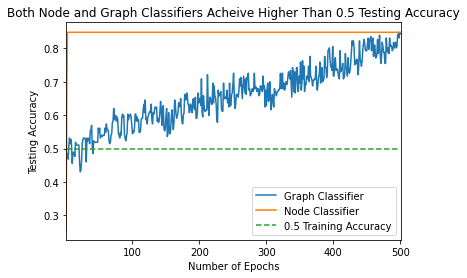

In [ ]:
# Plot the following:

epochs = range(1, 501)

# Epoch vs. Accuracy
plt.plot(epochs, accuraciesGraph, label = "Graph Classifier")
plt.plot(epochs, accuraciesNode, label = "Node Classifier")
plt.plot(epochs, [0.5]*len(epochs), '--', label = "0.5 Training Accuracy")

plt.xlabel("Number of Epochs")
plt.ylabel("Testing Accuracy")
plt.xlim(1, len(epochs)+1)
plt.legend(loc='lower right')
plt.title("Both Node and Graph Classifiers Acheive Higher Than 0.5 Testing Accuracy")


# Epoch vs. Precision

# Epoch vs. Recall



Text(0.5, 1.0, 'AUC Curve for Graph Classifier')

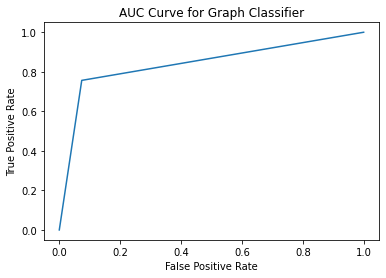

In [ ]:
# AUC for Graph Classification
plt.plot(fprGraph, tprGraph)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Curve for Graph Classifier")

Text(0.5, 1.0, 'Both Node and Graph Classifiers Acheive Less Than -log(1/2) Cross Entropy Loss')

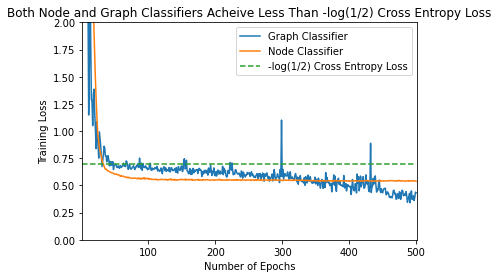

In [ ]:
# Epoch vs. Training Loss

plt.plot(epochs, lossesGraph, label = "Graph Classifier")
plt.plot(epochs, lossesNode, label = "Node Classifier")
plt.plot(epochs, [-math.log(1/2)]*len(epochs), '--', label = "-log(1/2) Cross Entropy Loss")
plt.xlim(1, len(epochs)+1)
plt.ylim(0, 2)

plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.legend(loc='upper right')

plt.title("Both Node and Graph Classifiers Acheive Less Than -log(1/2) Cross Entropy Loss")


Text(0.5, 1.0, 'AUC Curve for Node Classifier is Linear Due to Unproportional\nAmount of Crossovers in the Average Nanostructure')

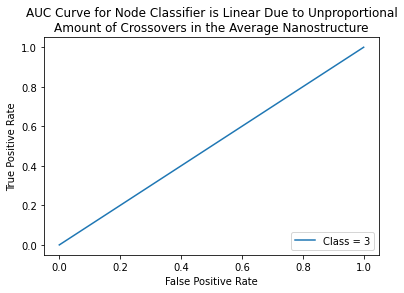

In [ ]:
assert(len(fprNode) == len(tprNode) == len(rocLabelsNode))
for i in range(len(fprNode)):
  labelToWrite = f"Class = {rocLabelsNode[i]}"
  plt.plot(fprNode[i], tprNode[i], label = labelToWrite)

plt.legend(loc='lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("AUC Curve for Node Classifier is Linear Due to Unproportional\nAmount of Crossovers in the Average Nanostructure")
